In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from dataset import get_manchester
from functionword_tagger import FunctionWordTagger
plt.rcParams['figure.figsize'] = 15, 6

In [2]:
unigrams, bigrams, trigrams = get_manchester("E:/project/Manchester/**/*", 
                                            cached=True, 
                                            gram_sizes=[1, 2, 3])

In [3]:
def morisita(a, b, drop_zeros=False, randomize=False):
    if randomize:
        b.index = np.random.permutation(b.index)
    if drop_zeros:
        df = pd.DataFrame({'a': a, 'b': b}).dropna(how='any')
        a, b = df.a, df.b
    else:
        a, b = a.align(b, fill_value=0)
    a = a / a.sum()
    b = b / b.sum()
    numer = np.dot(a, b)
    denom = np.square(a).sum() + np.square(b).sum()
    return 2 * numer / denom

def morisita_child_adult(df, drop_zeros=False):
    child = df[df.speaker.eq('CHI')].ngram.value_counts()
    adult = df[df.speaker.eq('MOT')].ngram.value_counts()
    return morisita(child, adult, drop_zeros=drop_zeros)

def morisita_adult_adult(df, corpus1, corpus2):
    adult1 = df[df.speaker.eq('MOT') & df.corpus.eq(corpus1)].ngram.value_counts()
    adult2 = df[df.speaker.eq('MOT') & df.corpus.eq(corpus2)].ngram.value_counts()
    return morisita(adult1, adult2)

def valid_ngram(ngram, shared_vocab): 
    "Returns true if the string `ngrams` only contains words from the shared vocab"
    for word in ngram.split(' '):
        if word not in shared_vocab:
            return False
    return True
  
def df_to_vocab(df):
    return set(word
        for pair in df.ngram.str.split(' ')
        for word in pair)

def common_vocab(df, attr='speaker'):
    values = df[attr].unique()
    if len(values) == 1:
        return {}
    elif len(values) > 2:
        raise Exception('Too many unique values exist for attr `{}`'.format(attr))
        
    first, second = values
    
    vocab_a = df[df[attr].eq(first)].pipe(df_to_vocab)
    vocab_b = df[df[attr].eq(second)].pipe(df_to_vocab)
    
    return vocab_a & vocab_b

def filter_to_common_vocab(df, attr='speaker'):
    vocab = common_vocab(df, attr=attr)
    return df[df.ngram.apply(lambda gram: valid_ngram(gram, vocab))]

def per_session_plot(title):
    plt.grid()
    plt.xticks(np.arange(1,35))
    plt.title(title)
    plt.legend()
    plt.xlabel('Session Number')
    plt.ylabel("Morisita's Overlap Index")
    plt.show()

plt.rcParams['figure.figsize'] = 15, 6
def plot_child(df, name, width=2, style='-', title=None, plot=True, ymax=1):
    m = df[df.corpus.eq(name)].groupby(['session']).apply(morisita_child_adult)
    m = m.align(pd.Series(index=np.arange(1, 35)))[0]
    plt.plot(stats.index, m, style, label=name, linewidth=width)
    if plot:
        per_session_plot(title or name)

def plot_all_children_together(df, name):
    children = unigrams.corpus.unique()
    from itertools import cycle, chain, repeat
    styles = cycle(chain(*(repeat(x, 10)
                     for x in '- -- -. :'.split(' '))))
    for index, child in enumerate(children):
        plot_child(df, child, 2, next(styles), plot=False)
    
    plt.legend();
    per_session_plot('Morisita Overlap Index for all children')
    
def vvv_format(title='', ylabel='', autoscale=False, min=0, max=1):

    plt.grid(True)
    plt.xticks(np.arange(1, 35, 4))

    #plt.title(title, fontsize=14)
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.xlabel('Session Number')
    if autoscale is False:
        plt.ylim(0, max)
    plt.ylabel(ylabel)
    plt.show()
    
plt.rcParams['figure.figsize'] = 12, 8
    
fontsize = 20
font = {'family' : 'sans-serif',
    'weight' : 'normal',
    'size'   : fontsize}

matplotlib.rc('font', **font)
matplotlib.rc('lines', lw=6)

COLORS = {
    'CHI': 'tab:blue',
    'MOT': 'tab:orange'
}
    
def per_session_plot(title, autoscale=False):
    vvv_format(title, "Morisita's Overlap Index", autoscale=autoscale)

In [4]:
def plot_child_adult_morisita(dataset, label):
    groups = dataset.groupby(['corpus', 'session']).apply(morisita_child_adult)
    stats = groups.groupby(level='session').describe()
    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
    plt.plot(stats.index, stats['min'])
    plt.plot(stats.index, stats['max'])
    plt.ylim(0, 1)
    per_session_plot(label)

In [5]:
def plot_adult_adult_morisita(dataset, label):
    groups = dataset.groupby(['corpus', 'session']).apply(morisita_adult_adult)
    stats = groups.groupby(level='session').describe()
    plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
    plt.plot(stats.index, stats['min'])
    plt.plot(stats.index, stats['max'])
    plt.ylim(0, 1)
    per_session_plot(label)

In [4]:
ftagger = FunctionWordTagger()

def categorize_ngram(ngram):
    return '/'.join(ftagger.categorize(word) for word in ngram.split(' '))

In [5]:
unigrams['fcat'] = unigrams.ngram.apply(categorize_ngram)
bigrams['fcat'] = bigrams.ngram.apply(categorize_ngram)

In [6]:
unigrams = unigrams[unigrams.speaker.isin(['CHI', 'MOT'])]
bigrams = bigrams[bigrams.speaker.isin(['CHI', 'MOT'])]
trigrams = trigrams[trigrams.speaker.isin(['CHI', 'MOT'])]

# Count function words

In [7]:
count_function = unigrams[(unigrams.fcat.eq('F'))&(unigrams.speaker.eq('CHI'))].groupby('ngram').size().to_frame().reset_index().rename(columns = {0:'count'})
count_function

,ngram,count
0,'d,7
1,'ll,79
2,'m,1001
3,'re,356
4,'s,19572
5,'ve,163
6,a,12727
7,aboard,1
8,about,219
9,across,4


In [8]:
z = {"before":"ambiguous",
"'d":"ambiguous",
"her":"ambiguous",
"once":"ambiguous",
"'s":"ambiguous",
"so":"ambiguous",
"until":"ambiguous",
"when":"ambiguous",
"where":"ambiguous",
"Am":"auxiliaries",
"are":"auxiliaries",
"Be":"auxiliaries",
"Been":"auxiliaries",
"Being":"auxiliaries",
"Did":"auxiliaries",
"Do":"auxiliaries",
"Does":"auxiliaries",
"doing":"auxiliaries",
"done":"auxiliaries",
"Is":"auxiliaries",
"'m":"auxiliaries",
"'re":"auxiliaries",
"'ve":"auxiliaries",
"Was":"auxiliaries",
"were":"auxiliaries",
"also":"conjunction",
"Although":"conjunction",
"And":"conjunction",
"because":"conjunction",
"but":"conjunction",
"hence":"conjunction",
"If":"conjunction",
"lest":"conjunction",
"nor":"conjunction",
"Or":"conjunction",
"Than":"conjunction",
"therefore":"conjunction",
"though":"conjunction",
"unless":"conjunction",
"Whereas":"conjunction",
"a":"determiner",
"an":"determiner",
"such":"determiner",
"that":"determiner",
"the":"determiner",
"these":"determiner",
"this":"determiner",
"Those":"determiner",
"ca":"modal",
"Can":"modal",
"cannot":"modal",
"Could":"modal",
"'ll":"modal",
"May":"modal",
"Might":"modal",
"Must":"modal",
"Ought":"modal",
"sha":"modal",
"Shall":"modal",
"should":"modal",
"Will":"modal",
"wo":"modal",
"Would":"modal",
"Eight":"number",
"Eighth":"number",
"Fifth":"number",
"First":"number",
"Five":"number",
"Four":"number",
"Fourth":"number",
"Nine":"number",
"Ninth":"number",
"One":"number",
"Second":"number",
"Seven":"number",
"Seventh":"number",
"Six":"number",
"Sixth":"number",
"Ten":"number",
"Tenth":"number",
"Third":"number",
"Three":"number",
"Two":"number",
"his":"possesive",
"Its":"possesive",
"my":"possesive",
"our":"possesive",
"their":"possesive",
"your":"possesive",
"aboard":"prepositions",
"about":"prepositions",
"Above":"prepositions",
"across":"prepositions",
"After":"prepositions",
"against":"prepositions",
"along":"prepositions",
"amid":"prepositions",
"Among":"prepositions",
"Around":"prepositions",
"At":"prepositions",
"back":"prepositions",
"behind":"prepositions",
"below":"prepositions",
"beneath":"prepositions",
"beside":"prepositions",
"between":"prepositions",
"Beyond":"prepositions",
"by":"prepositions",
"despite":"prepositions",
"down":"prepositions",
"During":"prepositions",
"for":"prepositions",
"From":"prepositions",
"in":"prepositions",
"inside":"prepositions",
"into":"prepositions",
"Near":"prepositions",
"of":"prepositions",
"off":"prepositions",
"On":"prepositions",
"Onto":"prepositions",
"opposite":"prepositions",
"out":"prepositions",
"outside":"prepositions",
"over":"prepositions",
"past":"prepositions",
"per":"prepositions",
"round":"prepositions",
"through":"prepositions",
"til":"prepositions",
"Till":"prepositions",
"to":"prepositions",
"toward":"prepositions",
"towards":"prepositions",
"under":"prepositions",
"underneath":"prepositions",
"up":"prepositions",
"upon":"prepositions",
"via":"prepositions",
"with":"prepositions",
"within":"prepositions",
"Without":"prepositions",
"anybody":"pronouns",
"anything":"pronouns",
"Everybody":"pronouns",
"Everyone":"pronouns",
"everything":"pronouns",
"He":"pronouns",
"Hers":"pronouns",
"Herself":"pronouns",
"Him":"pronouns",
"Himself":"pronouns",
"I":"pronouns",
"it":"pronouns",
"itself":"pronouns",
"Me":"pronouns",
"Mine":"pronouns",
"Myself":"pronouns",
"Nobody":"pronouns",
"none":"pronouns",
"others":"pronouns",
"ours":"pronouns",
"ourselves":"pronouns",
"She":"pronouns",
"Somebody":"pronouns",
"Someone":"pronouns",
"something":"pronouns",
"Their":"pronouns",
"Theirs":"pronouns",
"Them":"pronouns",
"Themselves":"pronouns",
"They":"pronouns",
"Us":"pronouns",
"we":"pronouns",
"You":"pronouns",
"Yours":"pronouns",
"Yourself":"pronouns",
"Yourselves":"pronouns",
"All":"quantifiers",
"Another":"quantifiers",
"Any":"quantifiers",
"Each":"quantifiers",
"Every":"quantifiers",
"Few":"quantifiers",
"Fewer":"quantifiers",
"Fewest":"quantifiers",
"least":"quantifiers",
"Less":"quantifiers",
"Lot":"quantifiers",
"Lots":"quantifiers",
"Many":"quantifiers",
"More":"quantifiers",
"Most":"quantifiers",
"Much":"quantifiers",
"Other":"quantifiers",
"Several":"quantifiers",
"Some":"quantifiers",
"How":"ambiguous",
"What":"ambiguous",
"Whence":"wh",
"Which":"ambiguous",
"whither":"wh",
"Who":"ambiguous",
"Whom":"ambiguous",
"Whose":"ambiguous",
"Why":"ambiguous",
"whenever":"wh",
"wherever":"wh",
"While":"wh"
}
z = dict((k.lower(), v)for k,v in z.items())
count_function['label'] = count_function['ngram'].map(z)
count_child = count_function.sort_values(by=['label']).reset_index().rename(columns = {'ngram':'ngram_child', 'count':'count_child'}).drop(['index'], axis = 1)
count_child

,ngram_child,count_child,label
0,'d,7,ambiguous
1,until,4,ambiguous
2,before,12,ambiguous
3,what,4674,ambiguous
4,her,699,ambiguous
5,once,4,ambiguous
6,when,205,ambiguous
7,how,162,ambiguous
8,which,89,ambiguous
9,where,3743,ambiguous


In [9]:
a = z.keys()-count_child['ngram_child'].unique()
b = list(zip(a, list(map(lambda k:z[k], a))))
sorted(b, key = lambda x: x[1])
difference = pd.DataFrame(b).sort_values(by = [1])
difference

,0,1
5,whom,ambiguous
0,therefore,conjunction
35,lest,conjunction
32,hence,conjunction
23,although,conjunction
18,nor,conjunction
15,whereas,conjunction
36,such,determiner
40,cannot,modal
38,wo,modal


In [10]:
writer = pd.ExcelWriter('count every function word child.xlsx')
difference.to_excel(writer,'Sheet2')
writer.save()

## Determiners_child

In [62]:
determiners = ['the', 'a', 'an', 'this', 'that', 'these','those', 'such']
n = 0
for unigram in count_function['ngram']:
    if unigram in determiners:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['count']
n = n / 12
n

4124.333333333333

## Conjunctions_child

In [63]:
conjunctions = ['for', 'And',
'therefore',
'nor',
'but',
'or',
'thence',
'then',
'yet',
'so',
'although',
'also',
'as',
'because',
'before',
'If',
'lest',
'since',
'than',
'once',
'only',
'though',
'til',
'unless',
'when',
'whenever',
'where',
'wherever',
'while',
'whereas',
'hence']
n = 0
for unigram in count_function['ngram']:
    if unigram in conjunctions:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['count']
n = n / 12
n

545.41666666666663

## prepositions_child

In [18]:
raw_prepositions = open("E:/project/formulae-project-master/prepositions.txt").readlines()
prepositions = []
for a in raw_prepositions:
    prepositions.append(a.strip())
prepositions = list(map(str.lower, prepositions))

n = 0
for unigram in count_function['ngram']:
    if unigram in prepositions:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n

5155.5

## pronouns_child

In [19]:
raw_pronouns = open("E:/project/formulae-project-master/pronouns.txt").readlines()
pronouns = []
for a in raw_pronouns:
    pronouns.append(a.strip())
pronouns = list(map(str.lower, pronouns))

n = 0
for unigram in count_function['ngram']:
    if unigram in pronouns:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n

3800.0833333333335

## auxiliaries_child

In [20]:
auxiliaries = ['be', 'am', 
'are',
'is',
'was',
'were',
'do',
'does',
'doing',
'did',
'done',
'got_to',
'been',
'being']
n = 0
for unigram in count_function['ngram']:
    if unigram in auxiliaries:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n

1346.9166666666667

## modals_child

In [21]:
modals = [
'can',
'cannot',
'could',
'should',
'shall',
'may',
'might',
'must',
'will',
'would',
'ought']
n = 0
for unigram in count_function['ngram']:
    if unigram in modals:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n

268.58333333333331

## quantifiers_child

In [22]:
raw_quantifiers = open("E:/project/formulae-project-master/quantifiers.txt").readlines()
quantifiers = []
for a in raw_quantifiers:
    quantifiers.append(a.strip())
quantifiers = list(map(str.lower, quantifiers))

n = 0
for unigram in count_function['ngram']:
    if unigram in quantifiers:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n

2803.0

## fragments_child

In [23]:
fragments = [
"'s",
"n't",
"'ve",
"ca",
"wo",
"'re",
"'m",
"'d",
"sha",
"'ll"]
n = 0
for unigram in count_function['ngram']:
    if unigram in fragments:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n


2476.0833333333335

## question words_child

In [24]:
question_words = [
'what',
'why',
'how',
'who',
'which',
'whose',
'whom',
'whence',
'whither']
n = 0
for unigram in count_function['ngram']:
    if unigram in question_words:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n

536.91666666666663

## number_child

In [25]:
number = [
'one',
'two',
'three',
'four',
'five',
'six',
'seven',
'eight',
'nine',
'ten',
'first',
'second',
'third',
'fourth',
'fifth',
'sixth',
'seventh',
'eighth',
'ninth',
'tenth']
n = 0
for unigram in count_function['ngram']:
    if unigram in number:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n


1019.8333333333334

In [11]:
count_function = unigrams[(unigrams.fcat.eq('F'))&(unigrams.speaker.eq('MOT'))].groupby('ngram').size().to_frame().reset_index().rename(columns = {0:'count'})

In [12]:
z = {"the":"determiner",
"a":"determiner",
"an":"determiner",
"this":"determiner",
"that":"determiner",
"these":"determiner",
"Those":"determiner",
"such":"determiner",
"And":"conjunction",
"therefore":"conjunction",
"nor":"conjunction",
"but":"conjunction",
"Or":"conjunction",
"Although":"conjunction",
"also":"conjunction",
"because":"conjunction",
"If":"conjunction",
"lest":"conjunction",
"Than":"conjunction",
"though":"conjunction",
"unless":"conjunction",
"Whereas":"conjunction",
"hence":"conjunction",
"whenever":"wh",
"wherever":"wh",
"While":"wh",
"for":"prepositions",
"aboard":"prepositions",
"about":"prepositions",
"Above":"prepositions",
"back":"prepositions",
"across":"prepositions",
"After":"prepositions",
"against":"prepositions",
"along":"prepositions",
"amid":"prepositions",
"Among":"prepositions",
"Around":"prepositions",
"At":"prepositions",
"behind":"prepositions",
"below":"prepositions",
"beneath":"prepositions",
"beside":"prepositions",
"between":"prepositions",
"Beyond":"prepositions",
"by":"prepositions",
"despite":"prepositions",
"down":"prepositions",
"During":"prepositions",
"From":"prepositions",
"in":"prepositions",
"inside":"prepositions",
"into":"prepositions",
"Near":"prepositions",
"of":"prepositions",
"off":"prepositions",
"On":"prepositions",
"Onto":"prepositions",
"out":"prepositions",
"opposite":"prepositions",
"outside":"prepositions",
"over":"prepositions",
"past":"prepositions",
"per":"prepositions",
"round":"prepositions",
"through":"prepositions",
"to":"prepositions",
"toward":"prepositions",
"towards":"prepositions",
"under":"prepositions",
"underneath":"prepositions",
"Till":"prepositions",
"til":"prepositions",
"up":"prepositions",
"upon":"prepositions",
"via":"prepositions",
"with":"prepositions",
"within":"prepositions",
"Without":"prepositions",
"my":"possesive",
"your":"possesive",
"his":"possesive",
"Its":"possesive",
"our":"possesive",
"their":"possesive",
"her":"pronouns",
"Hers":"pronouns",
"it":"pronouns",
"Us":"pronouns",
"we":"pronouns",
"ours":"pronouns",
"Theirs":"pronouns",
"He":"pronouns",
"She":"pronouns",
"I":"pronouns",
"You":"pronouns",
"Me":"pronouns",
"Him":"pronouns",
"They":"pronouns",
"Them":"pronouns",
"Mine":"pronouns",
"Ours":"pronouns",
"Their":"pronouns",
"Theirs":"pronouns",
"Yours":"pronouns",
"Herself":"pronouns",
"Himself":"pronouns",
"Myself":"pronouns",
"Yourself":"pronouns",
"itself":"pronouns",
"Yourselves":"pronouns",
"Themselves":"pronouns",
"ourselves":"pronouns",
"anything":"pronouns",
"others":"pronouns",
"anybody":"pronouns",
"Everybody":"pronouns",
"Nobody":"pronouns",
"Everyone":"pronouns",
"everything":"pronouns",
"Somebody":"pronouns",
"Someone":"pronouns",
"something":"pronouns",
"none":"pronouns",
"Be":"auxiliaries",
"Am":"auxiliaries",
"are":"auxiliaries",
"Is":"auxiliaries",
"Was":"auxiliaries",
"were":"auxiliaries",
"Do":"auxiliaries",
"Does":"auxiliaries",
"doing":"auxiliaries",
"Did":"auxiliaries",
"done":"auxiliaries",
"Been":"auxiliaries",
"Being":"auxiliaries",
"'ve":"auxiliaries",
"'re":"auxiliaries",
"'m":"auxiliaries",
"Can":"modal",
"cannot":"modal",
"Could":"modal",
"should":"modal",
"Shall":"modal",
"May":"modal",
"Might":"modal",
"Must":"modal",
"Will":"modal",
"Would":"modal",
"Ought":"modal",
"ca":"modal",
"wo":"modal",
"sha":"modal",
"'ll":"modal",
"All":"quantifiers",
"Any":"quantifiers",
"Another":"quantifiers",
"Other":"quantifiers",
"Each":"quantifiers",
"Every":"quantifiers",
"Few":"quantifiers",
"Fewer":"quantifiers",
"Fewest":"quantifiers",
"Less":"quantifiers",
"least":"quantifiers",
"Lot":"quantifiers",
"Lots":"quantifiers",
"Many":"quantifiers",
"More":"quantifiers",
"Most":"quantifiers",
"Much":"quantifiers",
"Several":"quantifiers",
"Some":"quantifiers",
"What":"question",
"Why":"question",
"How":"question",
"Who":"question",
"Which":"question",
"Whose":"question",
"Whom":"question",
"Whence":"question",
"whither":"question",
"where":"question",
"when":"question",
"One":"number",
"Two":"number",
"Three":"number",
"Four":"number",
"Five":"number",
"Six":"number",
"Seven":"number",
"Eight":"number",
"Nine":"number",
"Ten":"number",
"First":"number",
"Second":"number",
"Third":"number",
"Fourth":"number",
"Fifth":"number",
"Sixth":"number",
"Seventh":"number",
"Eighth":"number",
"Ninth":"number",
"Tenth":"number",
"so":"ambiguous",
"before":"ambiguous",
"once":"ambiguous",
"when":"ambiguous",
"where":"ambiguous",
"until":"ambiguous",
"her":"ambiguous",
"'s":"ambiguous",
"'d":"ambiguous"
}
z = dict((k.lower(), v)for k,v in z.items())

count_function['label'] = count_function['ngram'].map(z)
count_mother = count_function.sort_values(by=['label']).reset_index().rename(columns = {'ngram':'ngram_mother', 'count':'count_mother'}).drop(['index'], axis = 1)
count_mother

,ngram_mother,count_mother,label
0,'d,1232,ambiguous
1,once,96,ambiguous
2,so,2744,ambiguous
3,before,431,ambiguous
4,until,212,ambiguous
5,when,2007,ambiguous
6,where,6450,ambiguous
7,her,4103,ambiguous
8,'s,60167,ambiguous
9,does,5414,auxiliaries


In [13]:
a = z.keys()-count_mother['ngram_mother'].unique()
b = list(zip(a, list(map(lambda k:z[k], a))))
sorted(b, key = lambda x: x[1])
difference = pd.DataFrame(b).sort_values(by = [1])
difference

,0,1
0,whereas,conjunction
7,hence,conjunction
9,lest,conjunction
12,cannot,modal
2,ninth,number
5,seventh,number
13,fifth,number
1,beneath,prepositions
3,til,prepositions
4,amid,prepositions


In [14]:
writer = pd.ExcelWriter('count every function word mother.xlsx')
difference.to_excel(writer,'Sheet3')
writer.save()

## determiners_mother

In [37]:
determiners = ['the', 'a', 'an', 'this', 'that', 'these','those', 'such']
n = 0
for unigram in count_function['ngram']:
    if unigram in determiners:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n

10490.75

## conjunctions_mother

In [38]:
conjunctions = ['for', 'And',
'therefore',
'nor',
'but',
'or',
'thence',
'then',
'yet',
'so',
'although',
'also',
'as',
'because',
'before',
'If',
'lest',
'since',
'than',
'once',
'only',
'though',
'til',
'unless',
'when',
'whenever',
'where',
'wherever',
'while',
'whereas',
'hence']
n = 0
for unigram in count_function['ngram']:
    if unigram in conjunctions:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n

3185.4166666666665

## prepositions_mother

In [39]:
raw_prepositions = open("E:/project/formulae-project-master/prepositions.txt").readlines()
prepositions = []
for a in raw_prepositions:
    prepositions.append(a.strip())
prepositions = list(map(str.lower, prepositions))

n = 0
for unigram in count_function['ngram']:
    if unigram in prepositions:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n

12637.083333333334

## pronouns_mother

In [40]:
raw_pronouns = open("E:/project/formulae-project-master/pronouns.txt").readlines()
pronouns = []
for a in raw_pronouns:
    pronouns.append(a.strip())
pronouns = list(map(str.lower, pronouns))

n = 0
for unigram in count_function['ngram']:
    if unigram in pronouns:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n

17554.583333333332

## auxiliaries_mother

In [41]:
auxiliaries = ['be', 'am', 
'are',
'is',
'was',
'were',
'do',
'does',
'doing',
'did',
'done',
'got_to',
'been',
'being']
n = 0
for unigram in count_function['ngram']:
    if unigram in auxiliaries:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n

8569.75

## modals_mother

In [42]:
modals = [
'can',
'cannot',
'could',
'should',
'shall',
'may',
'might',
'must',
'will',
'would',
'ought']
n = 0
for unigram in count_function['ngram']:
    if unigram in modals:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n

2051.25

## quantifiers_mother

In [43]:
raw_quantifiers = open("E:/project/formulae-project-master/quantifiers.txt").readlines()
quantifiers = []
for a in raw_quantifiers:
    quantifiers.append(a.strip())
quantifiers = list(map(str.lower, quantifiers))

n = 0
for unigram in count_function['ngram']:
    if unigram in quantifiers:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n

4430.666666666667

## fragments_mother

In [44]:
fragments = [
"'s",
"n't",
"'ve",
"ca",
"wo",
"'re",
"'m",
"'d",
"sha",
"'ll"]
n = 0
for unigram in count_function['ngram']:
    if unigram in fragments:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n

10500.25

## question_words_mother

In [45]:
question_words = [
'what',
'why',
'how',
'who',
'which',
'whose',
'whom',
'whence',
'whither']
n = 0
for unigram in count_function['ngram']:
    if unigram in question_words:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n

3287.1666666666665

## number_mother

In [46]:
number = [
'one',
'two',
'three',
'four',
'five',
'six',
'seven',
'eight',
'nine',
'ten',
'first',
'second',
'third',
'fourth',
'fifth',
'sixth',
'seventh',
'eighth',
'ninth',
'tenth']
n = 0
for unigram in count_function['ngram']:
    if unigram in number:
        n += count_function[count_function.ngram.eq(unigram)].iloc[0]['fcat']
n = n / 12
n

1386.1666666666667

In [15]:
count_all = pd.concat([count_child, count_mother], axis  = 1)
count_all

,ngram_child,count_child,label,ngram_mother,count_mother,label
0,'d,7.0,ambiguous,'d,1232,ambiguous
1,until,4.0,ambiguous,once,96,ambiguous
2,before,12.0,ambiguous,so,2744,ambiguous
3,what,4674.0,ambiguous,before,431,ambiguous
4,her,699.0,ambiguous,until,212,ambiguous
5,once,4.0,ambiguous,when,2007,ambiguous
6,when,205.0,ambiguous,where,6450,ambiguous
7,how,162.0,ambiguous,her,4103,ambiguous
8,which,89.0,ambiguous,'s,60167,ambiguous
9,where,3743.0,ambiguous,does,5414,auxiliaries


In [16]:
writer = pd.ExcelWriter('count every function word.xlsx')
count_all.to_excel(writer,'Sheet1')
writer.save()

## Plot for counting function words

In [47]:
df = pd.read_excel('count function words.xlsx', )

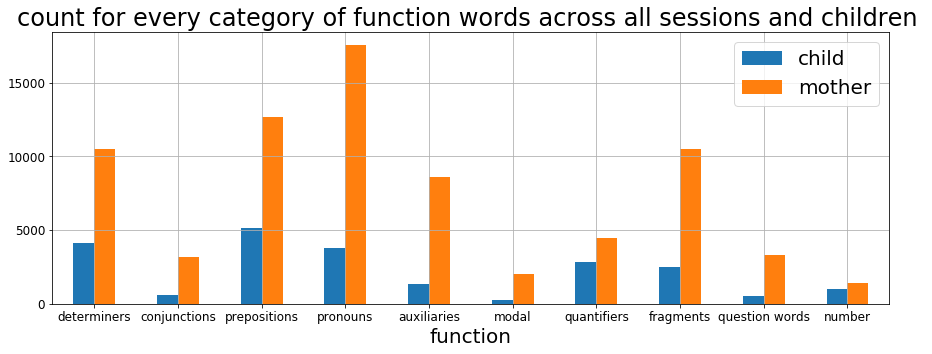

In [49]:
ax = df.set_index('function').plot.bar(rot=0, title='count for every category of function words across all sessions and children ', 
                                  figsize=(15,5), fontsize=12, grid = True)

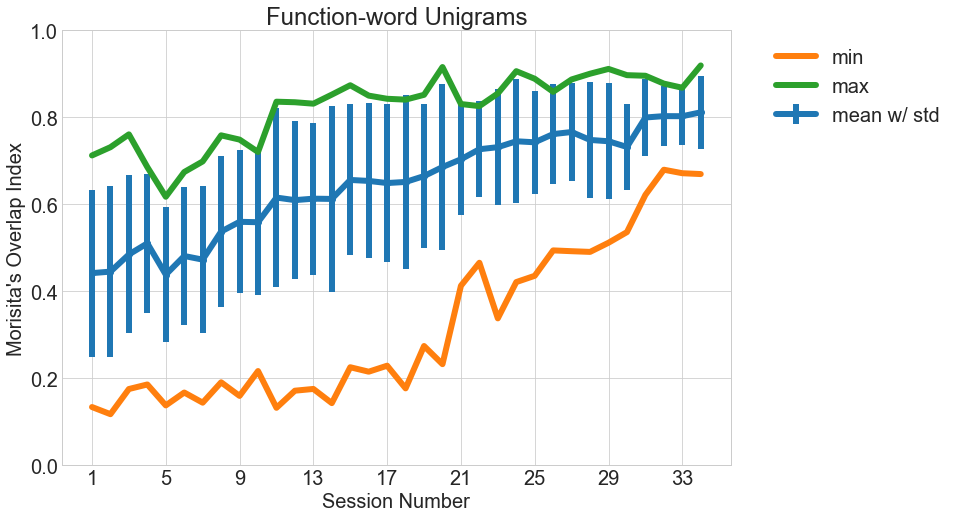

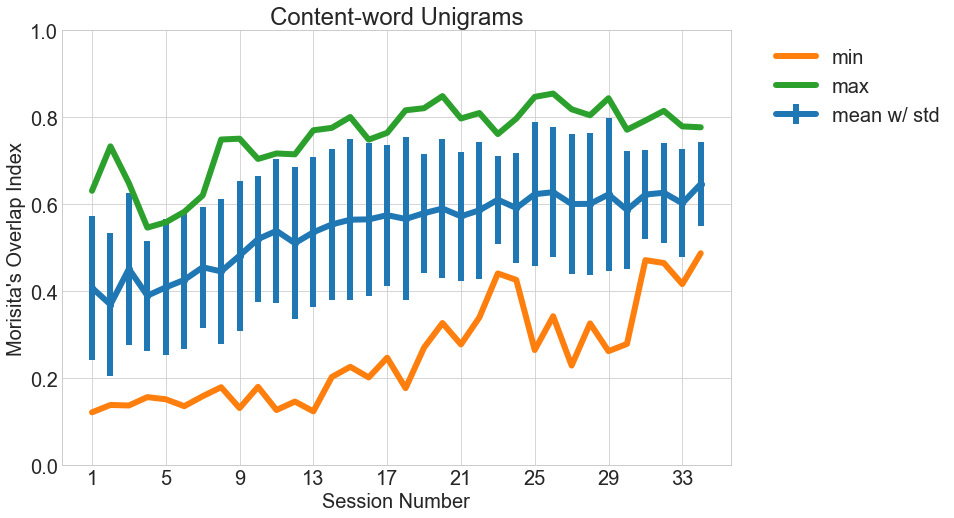

In [21]:
plt.style.use('seaborn-whitegrid')
plot_child_adult_morisita(unigrams[unigrams.fcat.eq('F')], 'Function-word Unigrams')
plot_child_adult_morisita(unigrams[unigrams.fcat.eq('C')], 'Content-word Unigrams')

## Types

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


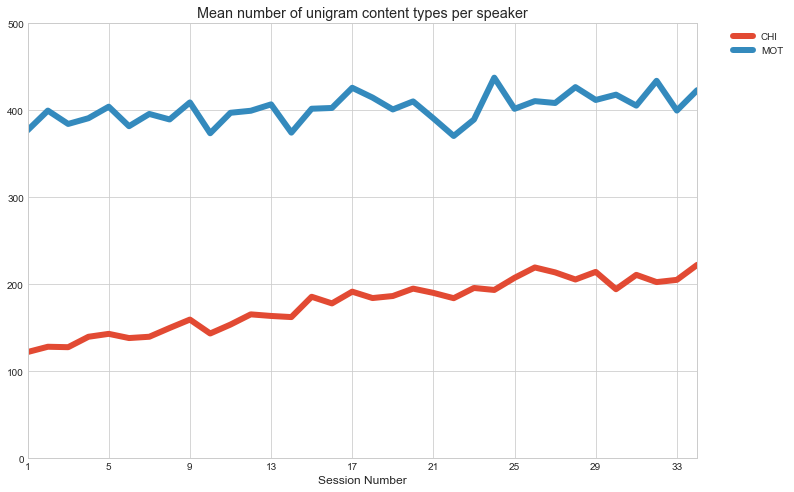

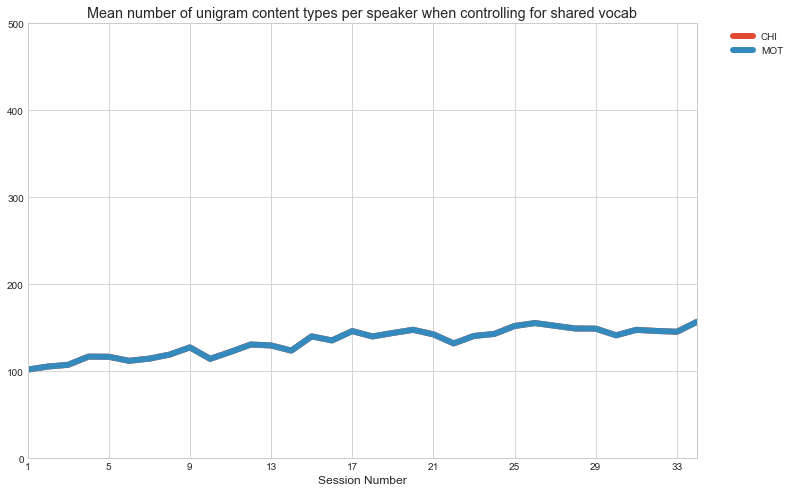

In [53]:
def mean_number_of_types_plots():
    unfiltered = (
        unigrams[unigrams.fcat.eq('C')]
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.nunique()
        .unstack()
        .groupby(level='session').mean()
    )

    filtered = (
        unigrams[unigrams.fcat.eq('C')]
        .groupby(['corpus', 'session'])
        .apply(filter_to_common_vocab)
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.nunique()
        .unstack()
        .groupby(level='session').mean()
    )
    
    unfiltered.plot()
    plt.ylim(0, 500)
    vvv_format(title='Mean number of unigram content types per speaker', autoscale=True)
    
    filtered.plot()
    plt.ylim(0, 500)
    vvv_format(title='Mean number of unigram content types per speaker when controlling for shared vocab', autoscale=True)     
        
mean_number_of_types_plots()    


E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


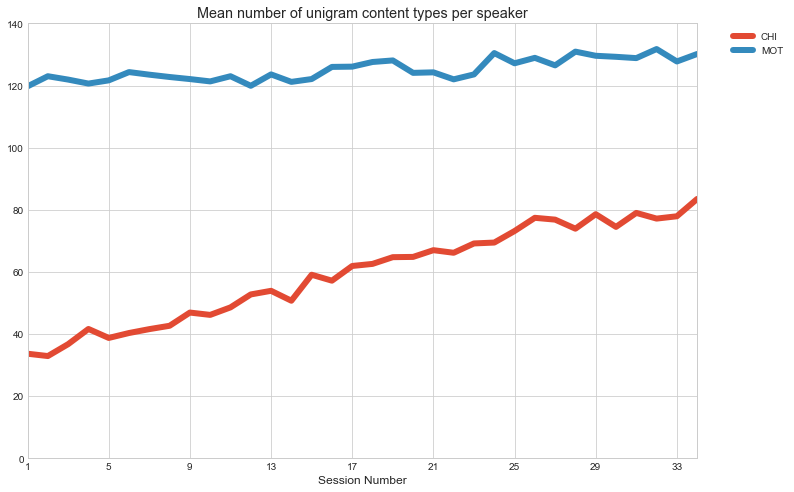

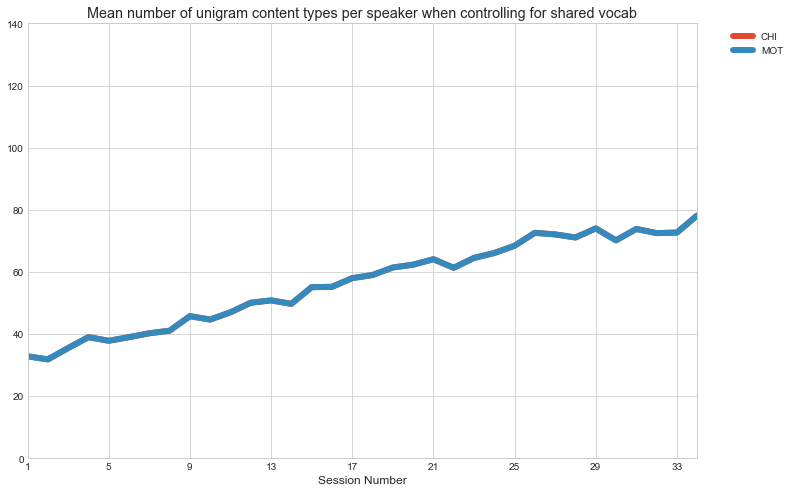

In [54]:
def mean_number_of_types_plots():
    unfiltered = (
        unigrams[unigrams.fcat.eq('F')]
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.nunique()
        .unstack()
        .groupby(level='session').mean()
    )
   
    filtered = (
        unigrams[unigrams.fcat.eq('F')]
        .groupby(['corpus', 'session'])
        .apply(filter_to_common_vocab)
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.nunique()
        .unstack()
        .groupby(level='session').mean()
    )
    
    unfiltered.plot()
    plt.ylim(0, 140)
    vvv_format(title='Mean number of unigram content types per speaker', autoscale=True)
    
    filtered.plot()
    plt.ylim(0, 140)
    vvv_format(title='Mean number of unigram content types per speaker when controlling for shared vocab', autoscale=True)  

mean_number_of_types_plots()  

### Function Unigram and Content Unigram

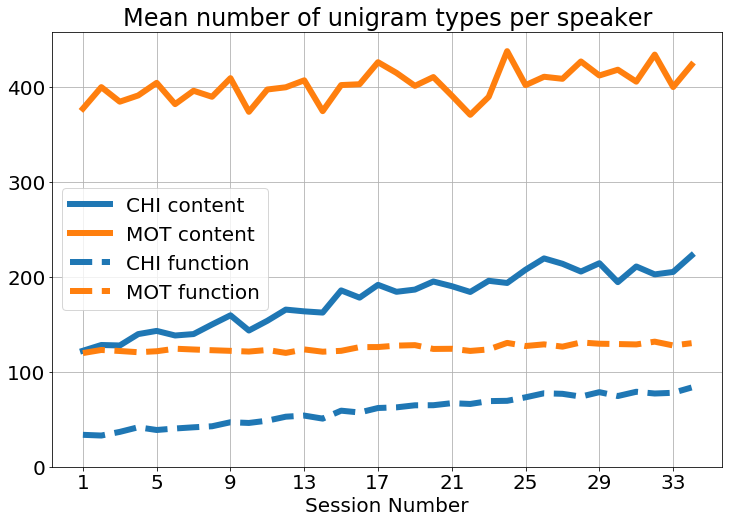

In [19]:
groups = unigrams[unigrams.fcat.eq('C')].groupby(['corpus', 'session', 'speaker']).ngram.nunique().unstack()
stats = groups.groupby(level='session').mean()

plt.plot(stats.CHI, label="CHI content", color=COLORS['CHI']);
plt.plot(stats.MOT, label="MOT content", color=COLORS['MOT']);

groups = unigrams[unigrams.fcat.eq('F')].groupby(['corpus', 'session', 'speaker']).ngram.nunique().unstack()
stats = groups.groupby(level='session').mean()

plt.plot(stats.CHI, label="CHI function", color=COLORS['CHI'], linestyle='--');
plt.plot(stats.MOT, label="MOT function", color=COLORS['MOT'], linestyle='--');
plt.legend()
plt.ylim(0)
vvv_format(autoscale=True, title='Mean number of unigram types per speaker')



E:\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  del sys.path[0]
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  del sys.path[0]
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version


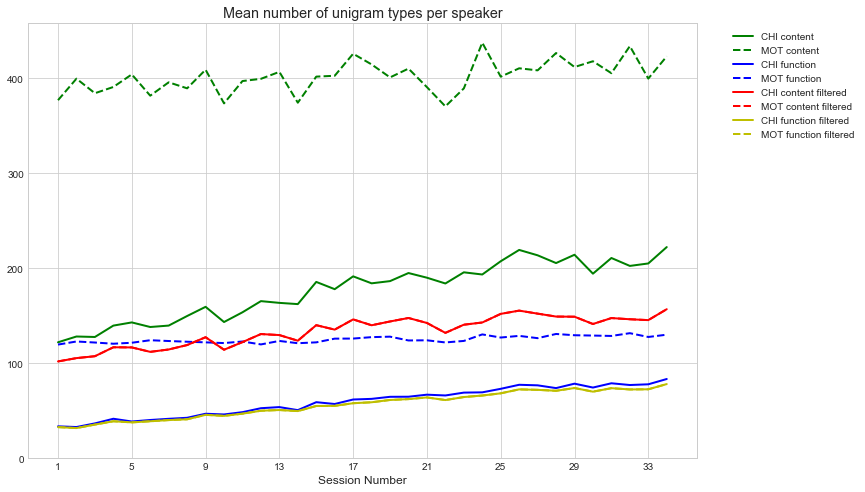

In [57]:
groups = unigrams[unigrams.fcat.eq('C')].groupby(['corpus', 'session', 'speaker']).ngram.nunique().unstack()
stats = groups.groupby(level='session').mean()

plt.plot(stats.CHI, label="CHI content", color='g', linewidth = 2);
plt.plot(stats.MOT, label="MOT content", color='g', linestyle = '--', linewidth = 2);

groups = unigrams[unigrams.fcat.eq('F')].groupby(['corpus', 'session', 'speaker']).ngram.nunique().unstack()
stats = groups.groupby(level='session').mean()

plt.plot(stats.CHI, label="CHI function", color='b', linewidth = 2);
plt.plot(stats.MOT, label="MOT function", color='b', linestyle='--', linewidth = 2);

groups = unigrams[unigrams.fcat.eq('C')].groupby(['corpus', 'session']).apply(filter_to_common_vocab).groupby(['corpus', 'session', 'speaker']).ngram.nunique().unstack().groupby(level='session').mean()
        
plt.plot(groups.CHI, label = 'CHI content filtered', color = 'r', linewidth = 2)
plt.plot(groups.MOT, label = 'MOT content filtered', color = 'r', linestyle = '--', linewidth = 2)

groups = unigrams[unigrams.fcat.eq('F')].groupby(['corpus', 'session']).apply(filter_to_common_vocab).groupby(['corpus', 'session', 'speaker']).ngram.nunique().unstack().groupby(level='session').mean()
        
plt.plot(groups.CHI, label = 'CHI function filtered', color = 'y', linewidth = 2)
plt.plot(groups.MOT, label = 'MOT function filtered', color = 'y', linestyle = '--', linewidth = 2)
   
plt.legend()
plt.ylim(0)
vvv_format(autoscale=True, title='Mean number of unigram types per speaker')

In [34]:
groups = unigrams[unigrams.fcat.eq('C')].groupby(['corpus', 'session', 'speaker']).ngram.size().unstack()

In [35]:
writer = pd.ExcelWriter('unigram content tokens.xlsx')
groups.to_excel(writer,'Sheet1')
writer.save()

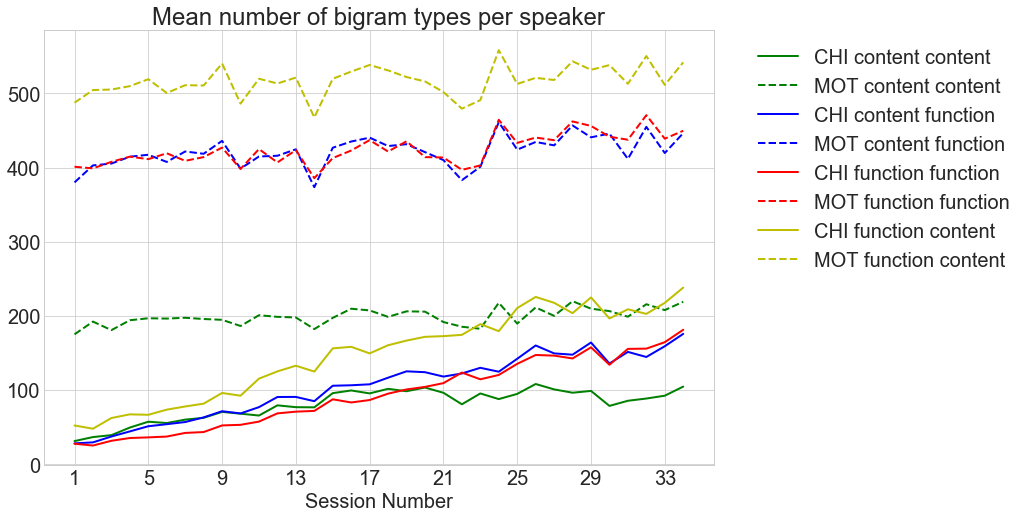

In [36]:
groups = bigrams[bigrams.fcat.eq('C/C')].groupby(['corpus', 'session', 'speaker']).ngram.nunique().unstack()
stats = groups.groupby(level='session').mean()

plt.plot(stats.CHI, label="CHI content content", color='g', linewidth = 2);
plt.plot(stats.MOT, label="MOT content content", color='g', linestyle = '--', linewidth = 2);

groups = bigrams[bigrams.fcat.eq('C/F')].groupby(['corpus', 'session', 'speaker']).ngram.nunique().unstack()
stats = groups.groupby(level='session').mean()

plt.plot(stats.CHI, label="CHI content function", color='b', linewidth = 2);
plt.plot(stats.MOT, label="MOT content function", color='b', linestyle='--', linewidth = 2);

groups = bigrams[bigrams.fcat.eq('F/F')].groupby(['corpus', 'session', 'speaker']).ngram.nunique().unstack()
stats = groups.groupby(level='session').mean()

plt.plot(stats.CHI, label="CHI function function", color='r', linewidth = 2);
plt.plot(stats.MOT, label="MOT function function", color='r', linestyle = '--', linewidth = 2);

groups = bigrams[bigrams.fcat.eq('F/C')].groupby(['corpus', 'session', 'speaker']).ngram.nunique().unstack()
stats = groups.groupby(level='session').mean()

plt.plot(stats.CHI, label="CHI function content", color='y', linewidth = 2);
plt.plot(stats.MOT, label="MOT function content", color='y', linestyle='--', linewidth = 2);


vvv_format(autoscale=True, title='Mean number of bigram types per speaker')


E:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: 'corpus' is 

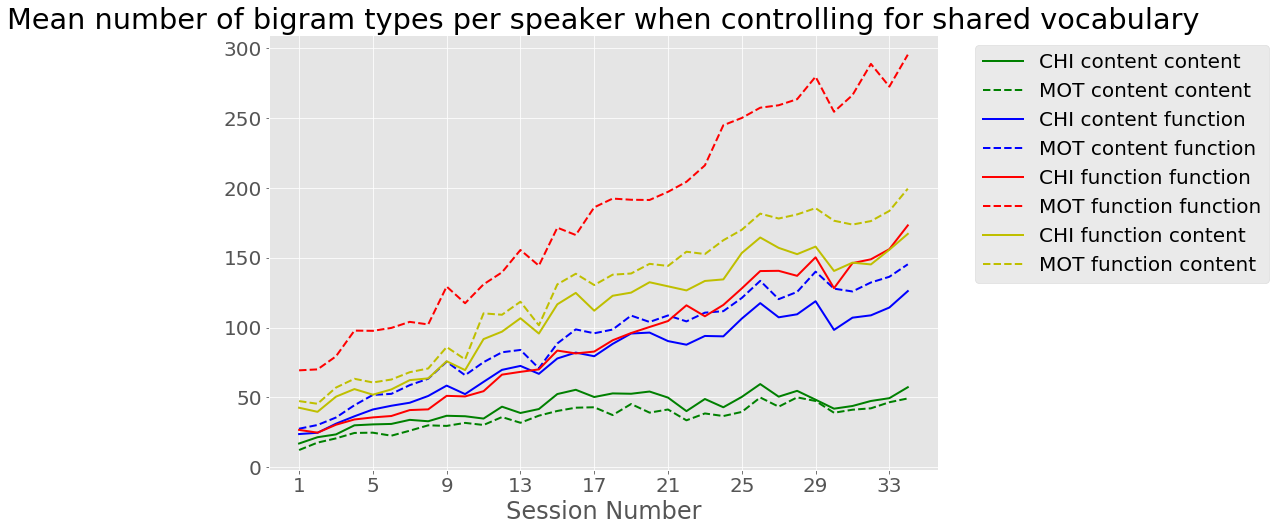

In [177]:
groups = bigrams[bigrams.fcat.eq('C/C')].groupby(['corpus', 'session']).apply(filter_to_common_vocab).groupby(['corpus', 'session', 'speaker']).ngram.nunique().unstack().groupby(level='session').mean()

plt.plot(groups.CHI, label="CHI content content", color='g', linewidth = 2);
plt.plot(groups.MOT, label="MOT content content", color='g', linestyle = '--', linewidth = 2);

groups = bigrams[bigrams.fcat.eq('C/F')].groupby(['corpus', 'session']).apply(filter_to_common_vocab).groupby(['corpus', 'session', 'speaker']).ngram.nunique().unstack().groupby(level='session').mean()

plt.plot(groups.CHI, label="CHI content function", color='b', linewidth = 2);
plt.plot(groups.MOT, label="MOT content function", color='b', linestyle='--', linewidth = 2);

groups = bigrams[bigrams.fcat.eq('F/F')].groupby(['corpus', 'session']).apply(filter_to_common_vocab).groupby(['corpus', 'session', 'speaker']).ngram.nunique().unstack().groupby(level='session').mean()

plt.plot(groups.CHI, label="CHI function function", color='r', linewidth = 2);
plt.plot(groups.MOT, label="MOT function function", color='r', linestyle = '--', linewidth = 2);

groups = bigrams[bigrams.fcat.eq('F/C')].groupby(['corpus', 'session']).apply(filter_to_common_vocab).groupby(['corpus', 'session', 'speaker']).ngram.nunique().unstack().groupby(level='session').mean()

plt.plot(groups.CHI, label="CHI function content", color='y', linewidth = 2);
plt.plot(groups.MOT, label="MOT function content", color='y', linestyle='--', linewidth = 2);


vvv_format(autoscale=True, title='Mean number of bigram types per speaker when controlling for shared vocabulary')

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


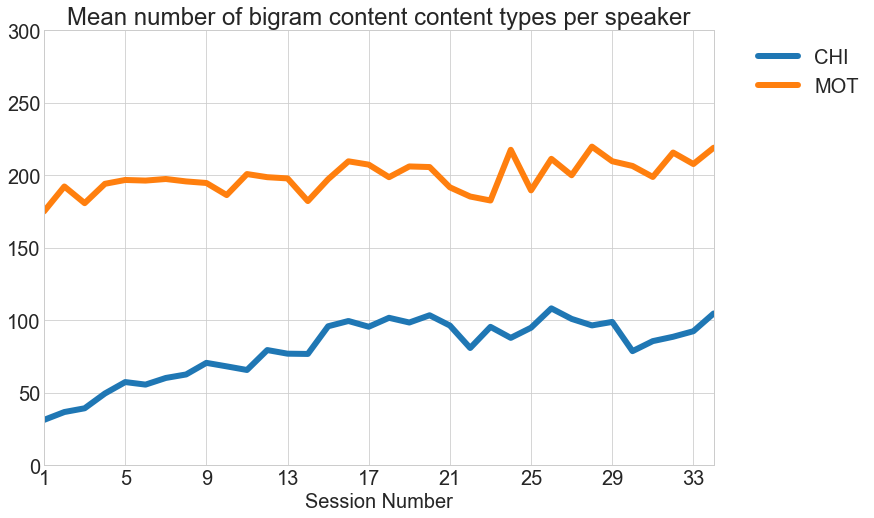

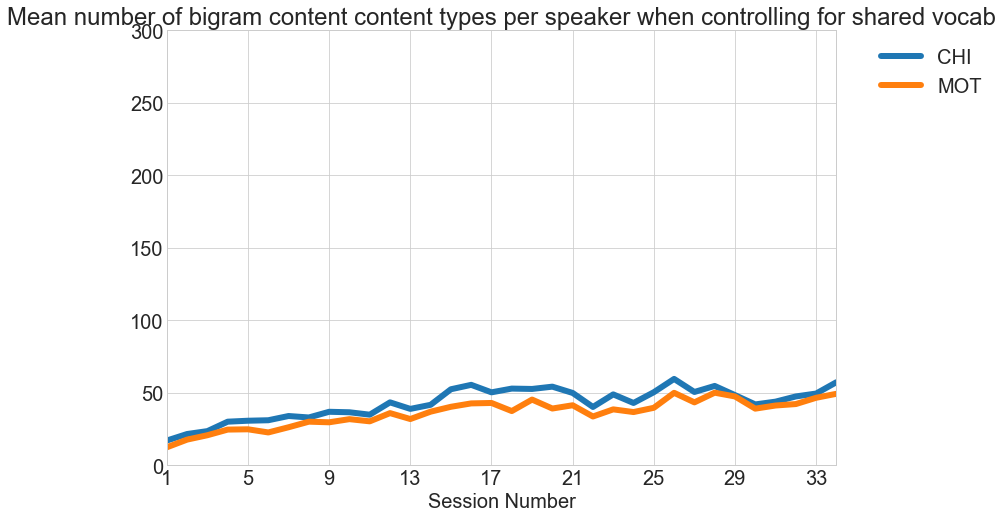

In [23]:
def mean_number_of_types_plots():
    unfiltered = (
        bigrams[bigrams.fcat.eq('C/C')]
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.nunique()
        .unstack()
        .groupby(level='session').mean()
    )
   
    filtered = (
        bigrams[bigrams.fcat.eq('C/C')]
        .groupby(['corpus', 'session'])
        .apply(filter_to_common_vocab)
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.nunique()
        .unstack()
        .groupby(level='session').mean()
    )
    
    unfiltered.plot()
    plt.ylim(0, 300)
    vvv_format(title='Mean number of bigram content content types per speaker', autoscale=True)
    
    filtered.plot()
    plt.ylim(0, 300)
    vvv_format(title='Mean number of bigram content content types per speaker when controlling for shared vocab', autoscale=True) 

mean_number_of_types_plots()  

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


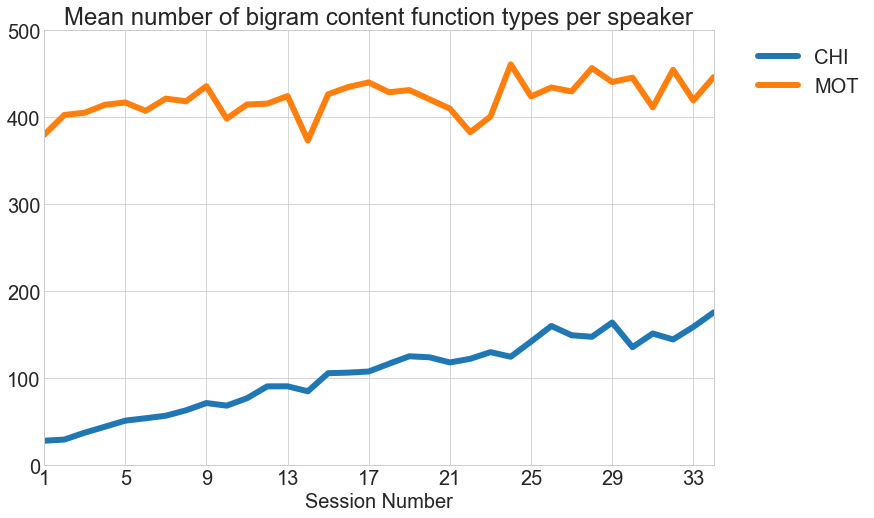

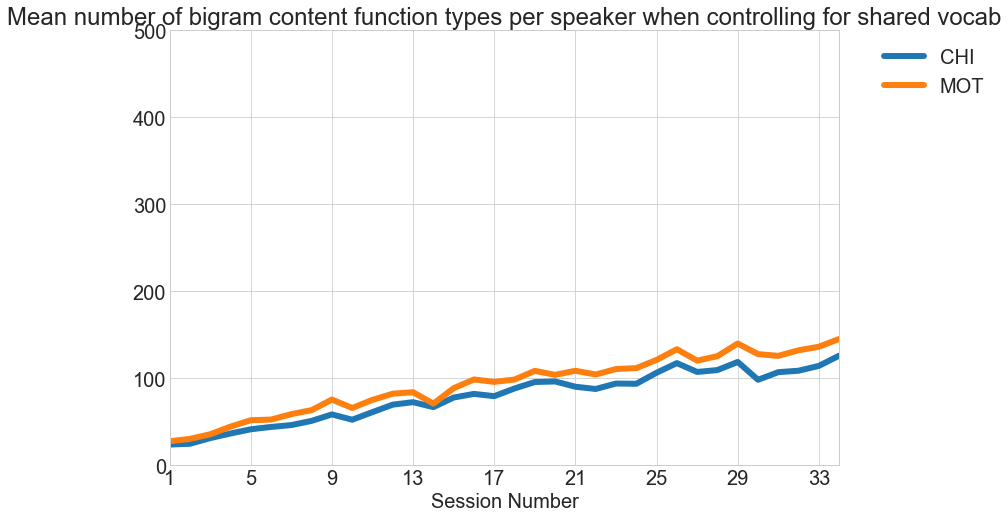

In [24]:
def mean_number_of_types_plots():
    unfiltered = (
        bigrams[bigrams.fcat.eq('C/F')]
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.nunique()
        .unstack()
        .groupby(level='session').mean()
    )
   
    filtered = (
        bigrams[bigrams.fcat.eq('C/F')]
        .groupby(['corpus', 'session'])
        .apply(filter_to_common_vocab)
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.nunique()
        .unstack()
        .groupby(level='session').mean()
    )
    
    unfiltered.plot()
    plt.ylim(0, 500)
    vvv_format(title='Mean number of bigram content function types per speaker', autoscale=True)
    
    filtered.plot()
    plt.ylim(0, 500)
    vvv_format(title='Mean number of bigram content function types per speaker when controlling for shared vocab', autoscale=True) 

mean_number_of_types_plots()  

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


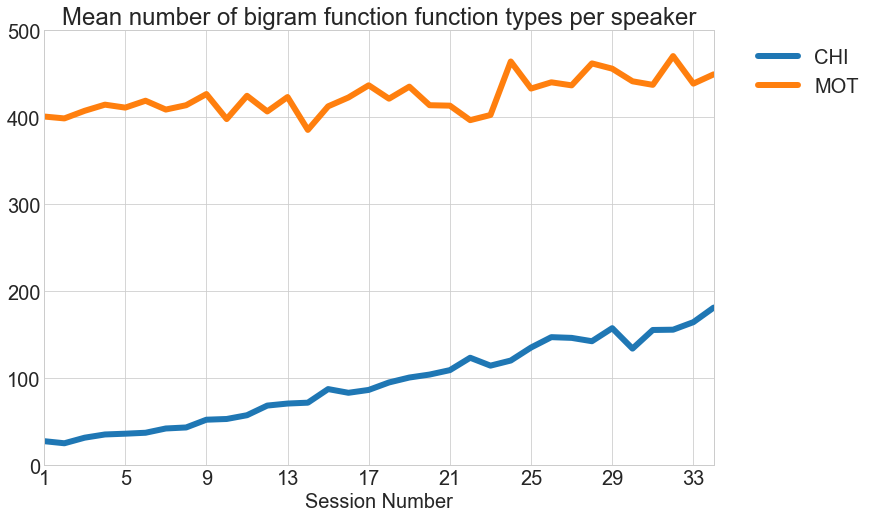

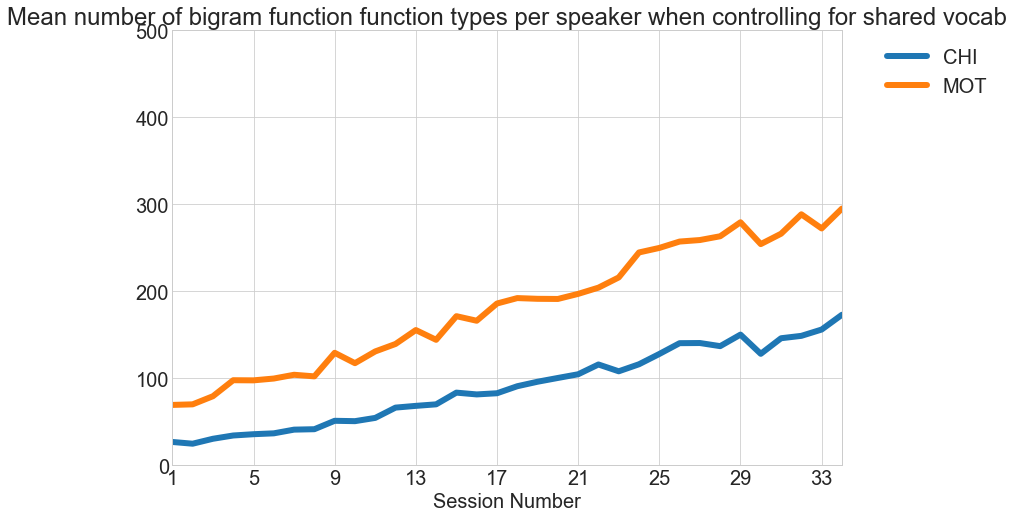

In [25]:
def mean_number_of_types_plots():
    unfiltered = (
        bigrams[bigrams.fcat.eq('F/F')]
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.nunique()
        .unstack()
        .groupby(level='session').mean()
    )
   
    filtered = (
        bigrams[bigrams.fcat.eq('F/F')]
        .groupby(['corpus', 'session'])
        .apply(filter_to_common_vocab)
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.nunique()
        .unstack()
        .groupby(level='session').mean()
    )
    
    unfiltered.plot()
    plt.ylim(0, 500)
    vvv_format(title='Mean number of bigram function function types per speaker', autoscale=True)
    
    filtered.plot()
    plt.ylim(0, 500)
    vvv_format(title='Mean number of bigram function function types per speaker when controlling for shared vocab', autoscale=True) 

mean_number_of_types_plots()  

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


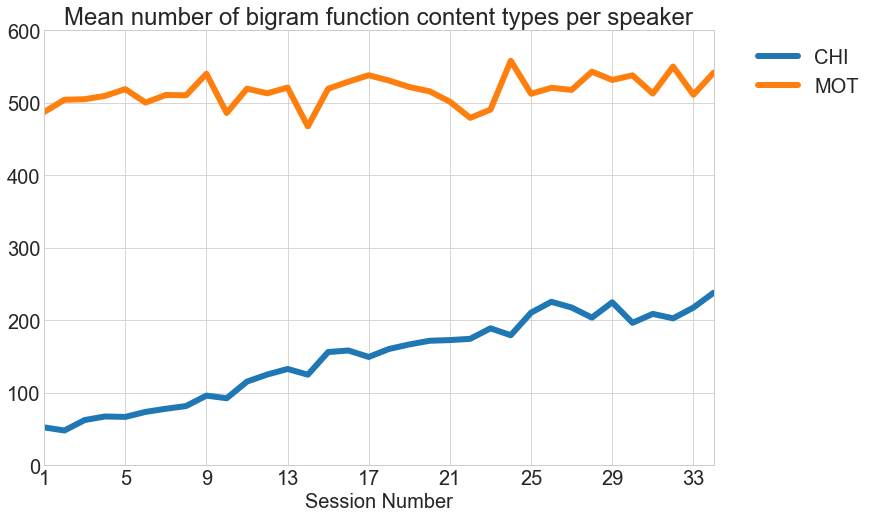

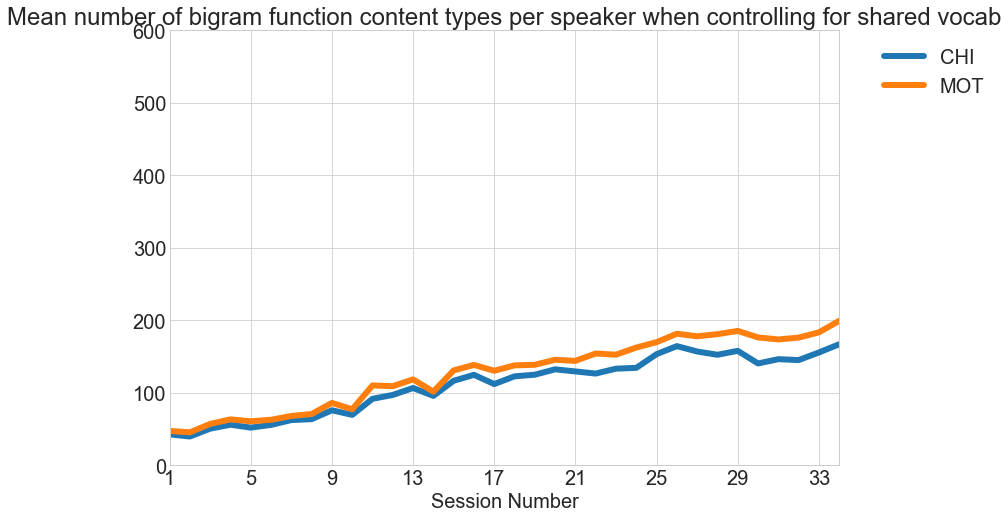

In [26]:
def mean_number_of_types_plots():
    unfiltered = (
        bigrams[bigrams.fcat.eq('F/C')]
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.nunique()
        .unstack()
        .groupby(level='session').mean()
    )
   
    filtered = (
        bigrams[bigrams.fcat.eq('F/C')]
        .groupby(['corpus', 'session'])
        .apply(filter_to_common_vocab)
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.nunique()
        .unstack()
        .groupby(level='session').mean()
    )
    
    unfiltered.plot()
    plt.ylim(0, 600)
    vvv_format(title='Mean number of bigram function content types per speaker', autoscale=True)
    
    filtered.plot()
    plt.ylim(0, 600)
    vvv_format(title='Mean number of bigram function content types per speaker when controlling for shared vocab', autoscale=True) 

mean_number_of_types_plots()  

## Tokens

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


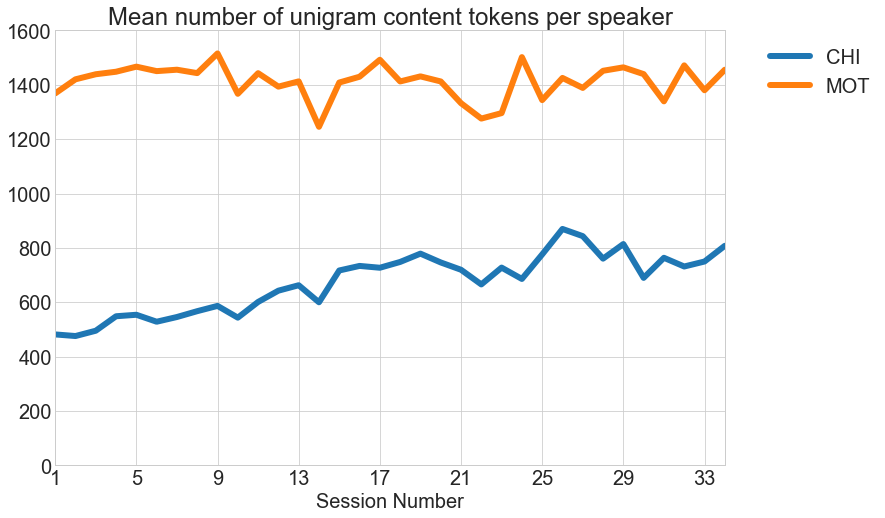

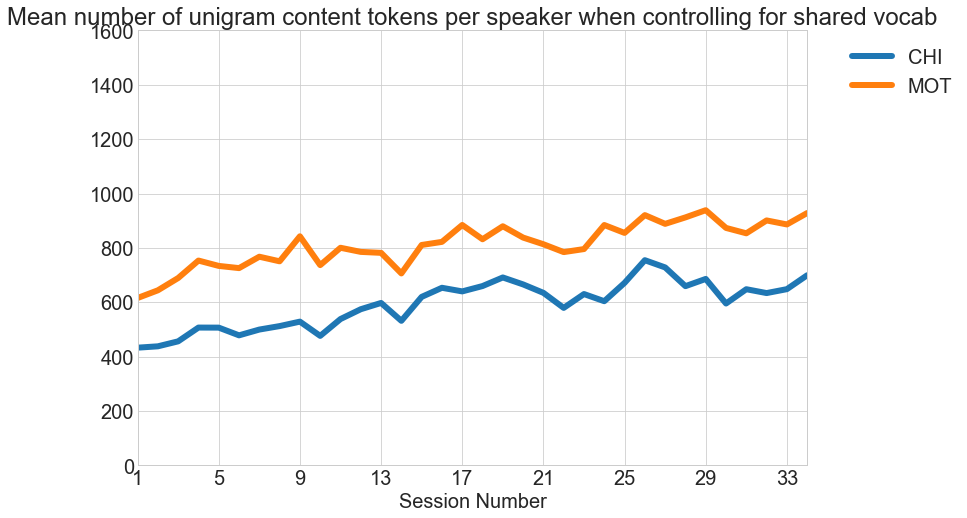

In [27]:
def mean_number_of_tokens_plots():
    unfiltered = (
        unigrams[unigrams.fcat.eq('C')]
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.size()
        .unstack()
        .groupby(level='session').mean()
    )
   
    filtered = (
        unigrams[unigrams.fcat.eq('C')]
        .groupby(['corpus', 'session'])
        .apply(filter_to_common_vocab)
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.size()
        .unstack()
        .groupby(level='session').mean()
    )
    
    unfiltered.plot()
    plt.ylim(0, 1600)
    vvv_format(title='Mean number of unigram content tokens per speaker', autoscale=True)
    
    filtered.plot()
    plt.ylim(0, 1600)
    vvv_format(title='Mean number of unigram content tokens per speaker when controlling for shared vocab', autoscale=True) 
    
mean_number_of_tokens_plots()   

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


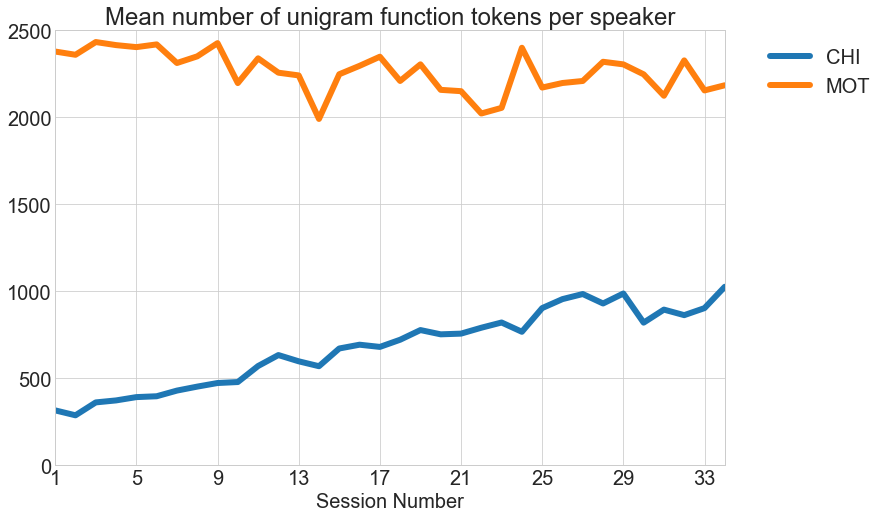

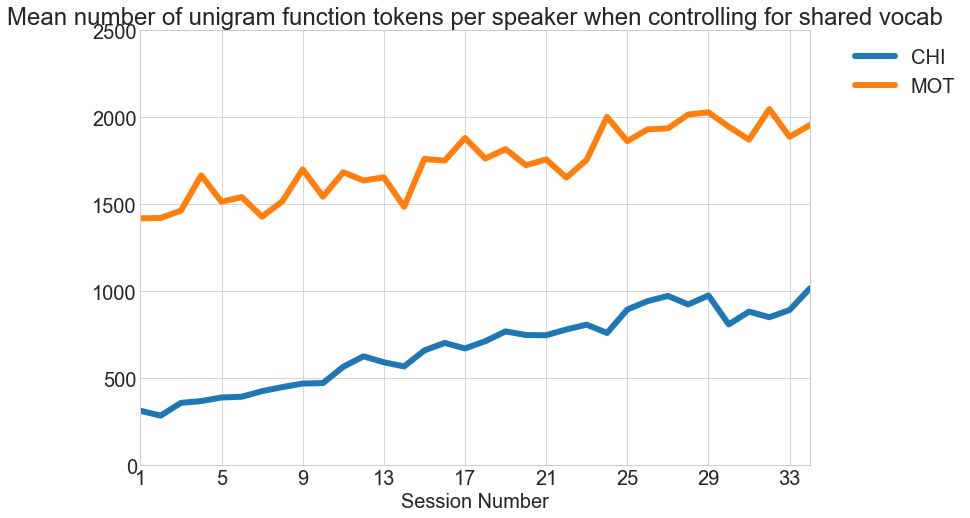

In [28]:
def mean_number_of_tokens_plots():
    unfiltered = (
        unigrams[unigrams.fcat.eq('F')]
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.size()
        .unstack()
        .groupby(level='session').mean()
    )
   
    filtered = (
        unigrams[unigrams.fcat.eq('F')]
        .groupby(['corpus', 'session'])
        .apply(filter_to_common_vocab)
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.size()
        .unstack()
        .groupby(level='session').mean()
    )
    
    unfiltered.plot()
    plt.ylim(0, 2500)
    vvv_format(title='Mean number of unigram function tokens per speaker', autoscale=True)
    
    filtered.plot()
    plt.ylim(0, 2500)
    vvv_format(title='Mean number of unigram function tokens per speaker when controlling for shared vocab', autoscale=True) 
    
mean_number_of_tokens_plots()   

### Function Unigram and Content Unigram

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  del sys.path[0]
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  del sys.path[0]
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version


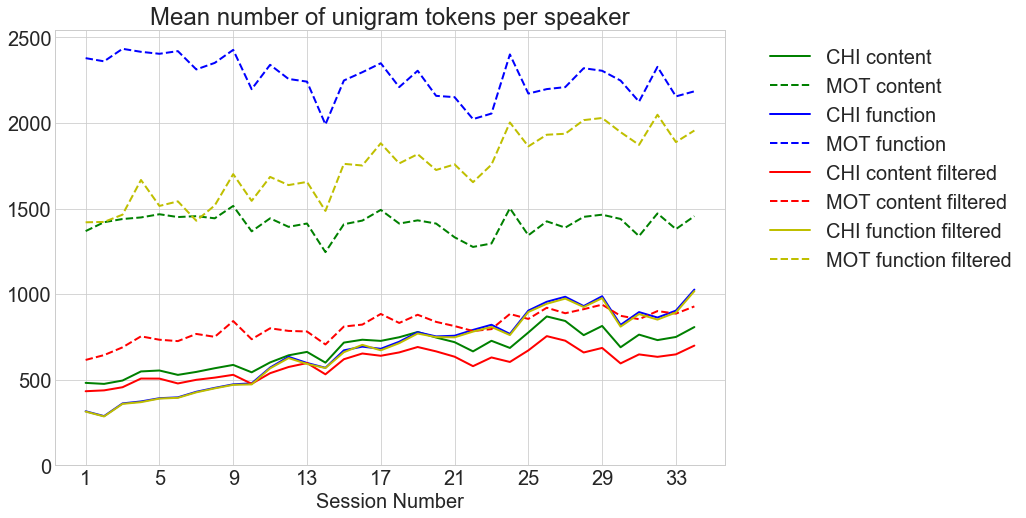

In [29]:
groups = unigrams[unigrams.fcat.eq('C')].groupby(['corpus', 'session', 'speaker']).ngram.size().unstack()
stats = groups.groupby(level='session').mean()

plt.plot(stats.CHI, label="CHI content", color='g', linewidth = 2);
plt.plot(stats.MOT, label="MOT content", color='g', linestyle = '--', linewidth = 2);

groups = unigrams[unigrams.fcat.eq('F')].groupby(['corpus', 'session', 'speaker']).ngram.size().unstack()
stats = groups.groupby(level='session').mean()

plt.plot(stats.CHI, label="CHI function", color='b', linewidth = 2);
plt.plot(stats.MOT, label="MOT function", color='b', linestyle='--', linewidth = 2);

groups = unigrams[unigrams.fcat.eq('C')].groupby(['corpus', 'session']).apply(filter_to_common_vocab).groupby(['corpus', 'session', 'speaker']).ngram.size().unstack().groupby(level='session').mean()
        
plt.plot(groups.CHI, label = 'CHI content filtered', color = 'r', linewidth = 2)
plt.plot(groups.MOT, label = 'MOT content filtered', color = 'r', linestyle = '--', linewidth = 2)

groups = unigrams[unigrams.fcat.eq('F')].groupby(['corpus', 'session']).apply(filter_to_common_vocab).groupby(['corpus', 'session', 'speaker']).ngram.size().unstack().groupby(level='session').mean()
        
plt.plot(groups.CHI, label = 'CHI function filtered', color = 'y', linewidth = 2)
plt.plot(groups.MOT, label = 'MOT function filtered', color = 'y', linestyle = '--', linewidth = 2)
   
plt.legend()
plt.ylim(0)
vvv_format(autoscale=True, title='Mean number of unigram tokens per speaker')

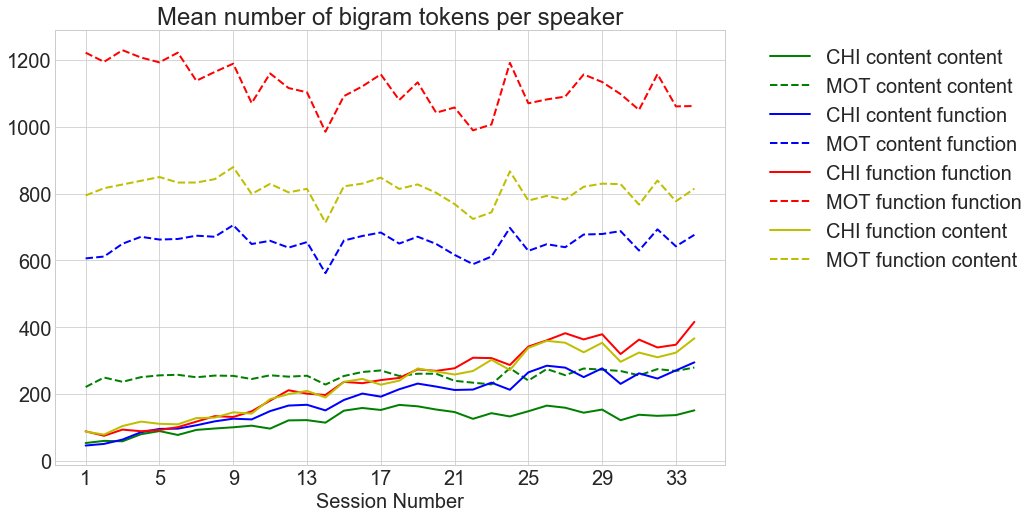

In [30]:
groups = bigrams[bigrams.fcat.eq('C/C')].groupby(['corpus', 'session', 'speaker']).ngram.size().unstack()
stats = groups.groupby(level = 'session').mean()

plt.plot(stats.CHI, label="CHI content content", color='g', linewidth = 2);
plt.plot(stats.MOT, label="MOT content content", color='g', linestyle = '--', linewidth = 2);

groups = bigrams[bigrams.fcat.eq('C/F')].groupby(['corpus', 'session', 'speaker']).ngram.size().unstack()
stats = groups.groupby(level='session').mean()

plt.plot(stats.CHI, label="CHI content function", color='b', linewidth = 2);
plt.plot(stats.MOT, label="MOT content function", color='b', linestyle='--', linewidth = 2);

groups = bigrams[bigrams.fcat.eq('F/F')].groupby(['corpus', 'session', 'speaker']).ngram.size().unstack()
stats = groups.groupby(level='session').mean()

plt.plot(stats.CHI, label="CHI function function", color='r', linewidth = 2);
plt.plot(stats.MOT, label="MOT function function", color='r', linestyle = '--', linewidth = 2);

groups = bigrams[bigrams.fcat.eq('F/C')].groupby(['corpus', 'session', 'speaker']).ngram.size().unstack()
stats = groups.groupby(level='session').mean()

plt.plot(stats.CHI, label="CHI function content", color='y', linewidth = 2);
plt.plot(stats.MOT, label="MOT function content", color='y', linestyle='--', linewidth = 2);


vvv_format(autoscale=True, title='Mean number of bigram tokens per speaker')

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: 'corpus' is 

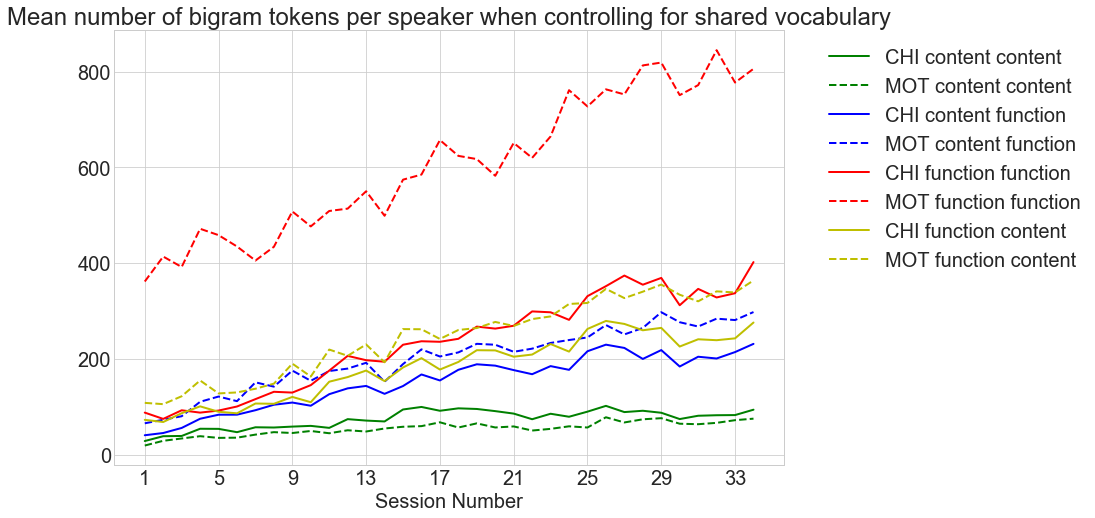

In [31]:
groups = bigrams[bigrams.fcat.eq('C/C')].groupby(['corpus', 'session']).apply(filter_to_common_vocab).groupby(['corpus', 'session', 'speaker']).ngram.size().unstack().groupby(level='session').mean()

plt.plot(groups.CHI, label="CHI content content", color='g', linewidth = 2);
plt.plot(groups.MOT, label="MOT content content", color='g', linestyle = '--', linewidth = 2);

groups = bigrams[bigrams.fcat.eq('C/F')].groupby(['corpus', 'session']).apply(filter_to_common_vocab).groupby(['corpus', 'session', 'speaker']).ngram.size().unstack().groupby(level='session').mean()

plt.plot(groups.CHI, label="CHI content function", color='b', linewidth = 2);
plt.plot(groups.MOT, label="MOT content function", color='b', linestyle='--', linewidth = 2);

groups = bigrams[bigrams.fcat.eq('F/F')].groupby(['corpus', 'session']).apply(filter_to_common_vocab).groupby(['corpus', 'session', 'speaker']).ngram.size().unstack().groupby(level='session').mean()

plt.plot(groups.CHI, label="CHI function function", color='r', linewidth = 2);
plt.plot(groups.MOT, label="MOT function function", color='r', linestyle = '--', linewidth = 2);

groups = bigrams[bigrams.fcat.eq('F/C')].groupby(['corpus', 'session']).apply(filter_to_common_vocab).groupby(['corpus', 'session', 'speaker']).ngram.size().unstack().groupby(level='session').mean()

plt.plot(groups.CHI, label="CHI function content", color='y', linewidth = 2);
plt.plot(groups.MOT, label="MOT function content", color='y', linestyle='--', linewidth = 2);


vvv_format(autoscale=True, title='Mean number of bigram tokens per speaker when controlling for shared vocabulary')

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  from ipykernel import kernelapp as app
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  from ipykernel import kernelapp as app


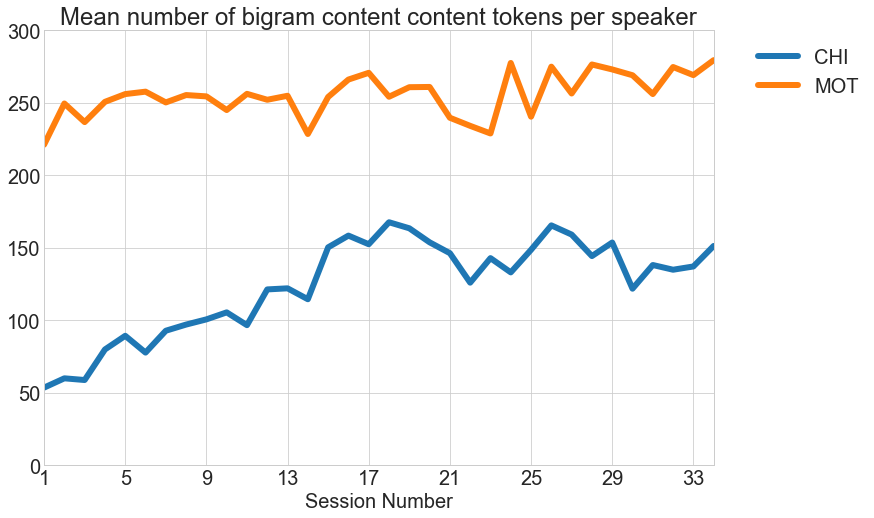

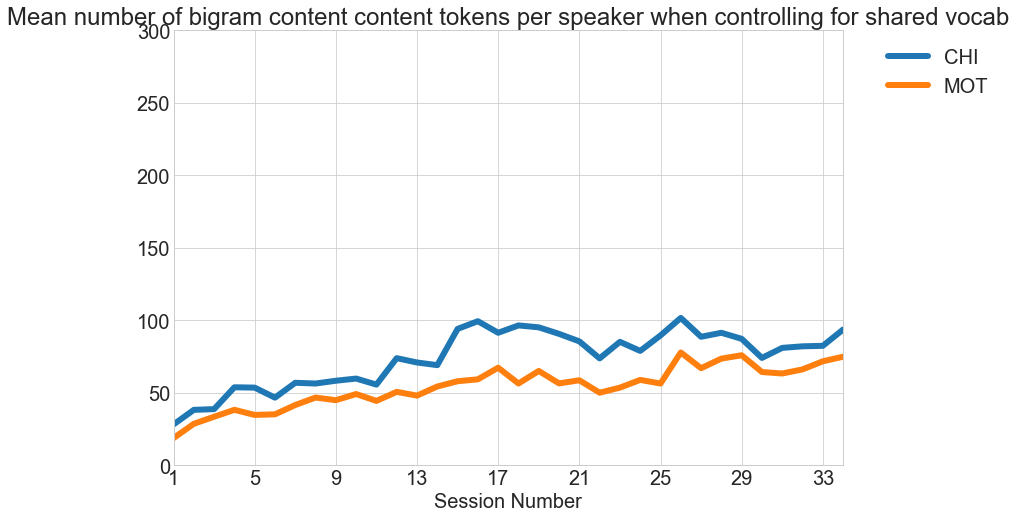

In [32]:
def mean_number_of_tokens_plots():
    unfiltered = (
        bigrams[bigrams.fcat.eq('C/C')]
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.size()
        .unstack()
        .groupby(level='session').mean()
    )
   
    
    filtered = (
        bigrams[bigrams.fcat.eq('C/C')]
        .groupby(['corpus', 'session'])
        .apply(filter_to_common_vocab)
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.size()
        .unstack()
        .groupby(level='session').mean()
    )
    
    unfiltered.plot()
    plt.ylim(0, 300)
    vvv_format(title='Mean number of bigram content content tokens per speaker', autoscale=True)
    
    filtered.plot()
    plt.ylim(0, 300)
    vvv_format(title='Mean number of bigram content content tokens per speaker when controlling for shared vocab', autoscale=True) 


mean_number_of_tokens_plots()

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  del sys.path[0]
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  del sys.path[0]


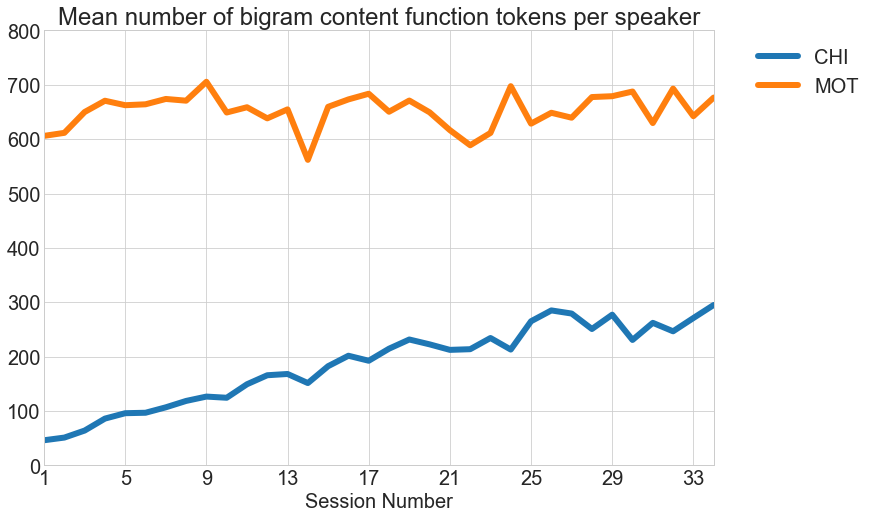

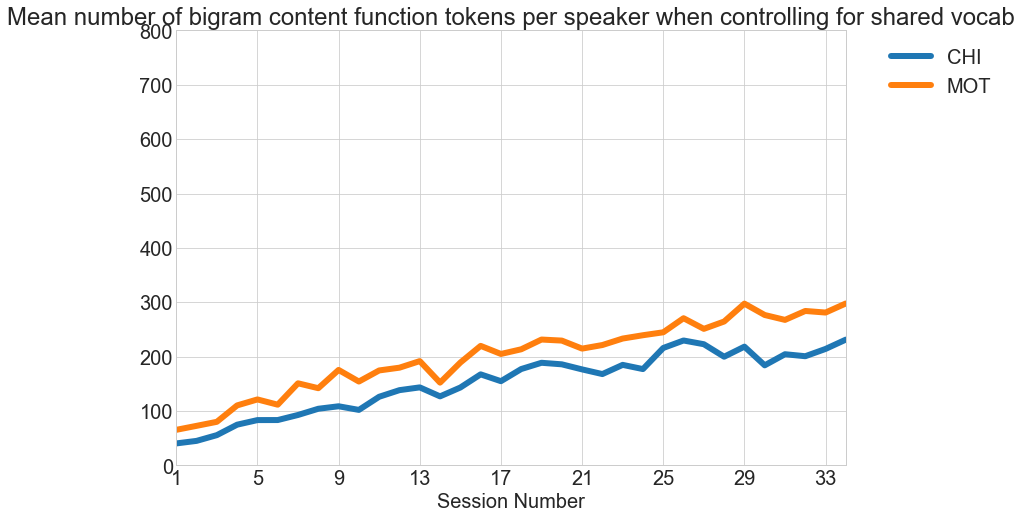

In [33]:
def mean_number_of_tokens_plots():
    unfiltered = (
        bigrams[bigrams.fcat.eq('C/F')]
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.size()
        .unstack()
        .groupby(level='session').mean()
    )
    filtered = (
        bigrams[bigrams.fcat.eq('C/F')]
        .groupby(['corpus', 'session'])
        .apply(filter_to_common_vocab)
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.size()
        .unstack()
        .groupby(level='session').mean()
    )
    
    unfiltered.plot()
    plt.ylim(0, 800)
    vvv_format(title='Mean number of bigram content function tokens per speaker', autoscale=True)
    
    filtered.plot()
    plt.ylim(0, 800)
    vvv_format(title='Mean number of bigram content function tokens per speaker when controlling for shared vocab', autoscale=True) 

mean_number_of_tokens_plots()

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


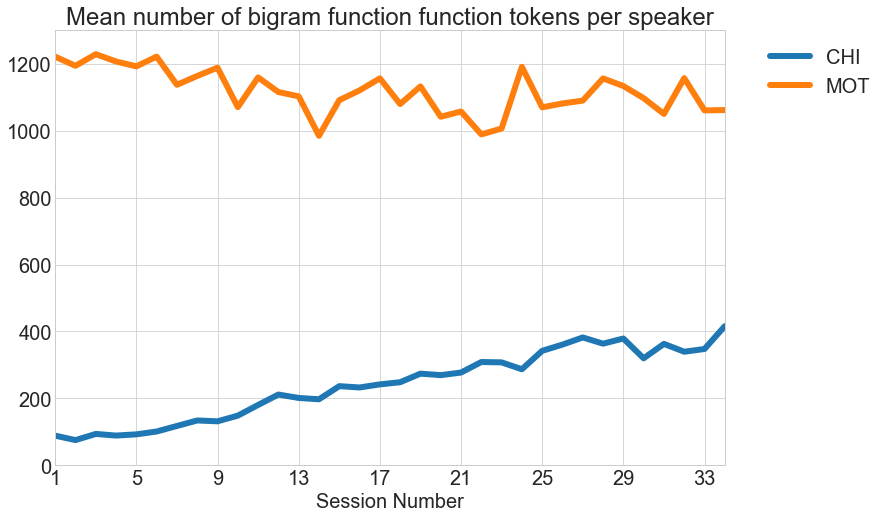

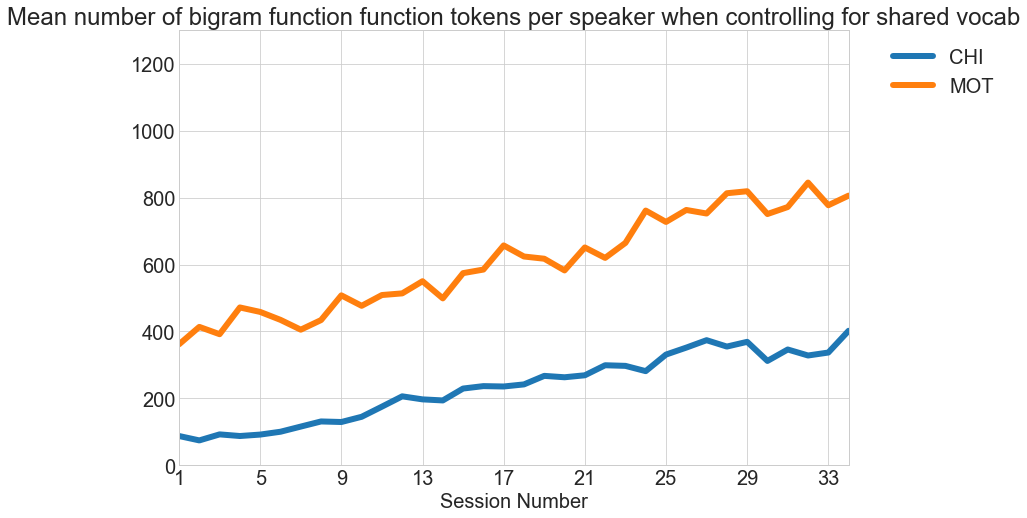

In [34]:
def mean_number_of_tokens_plots():
    unfiltered = (
        bigrams[bigrams.fcat.eq('F/F')]
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.size()
        .unstack()
        .groupby(level='session').mean()
    )
   
    filtered = (
        bigrams[bigrams.fcat.eq('F/F')]
        .groupby(['corpus', 'session'])
        .apply(filter_to_common_vocab)
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.size()
        .unstack()
        .groupby(level='session').mean()
    )
    
    unfiltered.plot()
    plt.ylim(0, 1300)
    vvv_format(title='Mean number of bigram function function tokens per speaker', autoscale=True)
    
    filtered.plot()
    plt.ylim(0, 1300)
    vvv_format(title='Mean number of bigram function function tokens per speaker when controlling for shared vocab', autoscale=True)
    
mean_number_of_tokens_plots()

E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'corpus' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  
E:\anaconda3\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: 'session' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  


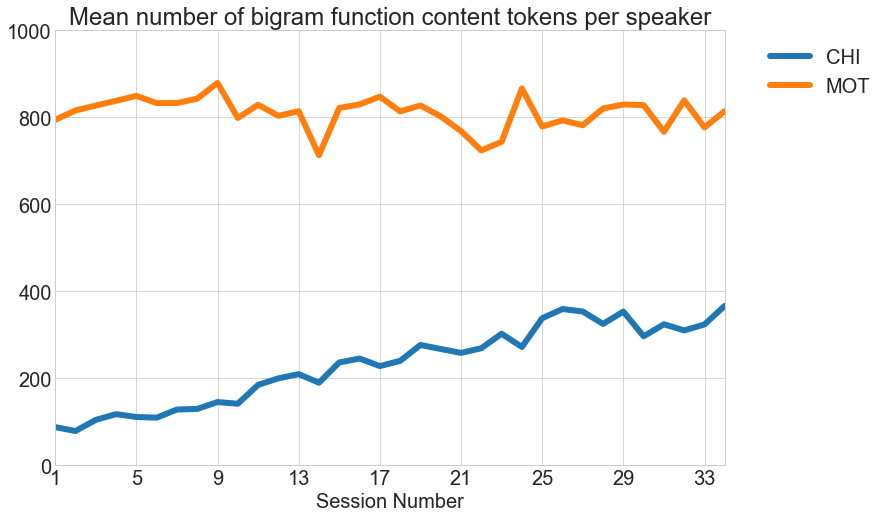

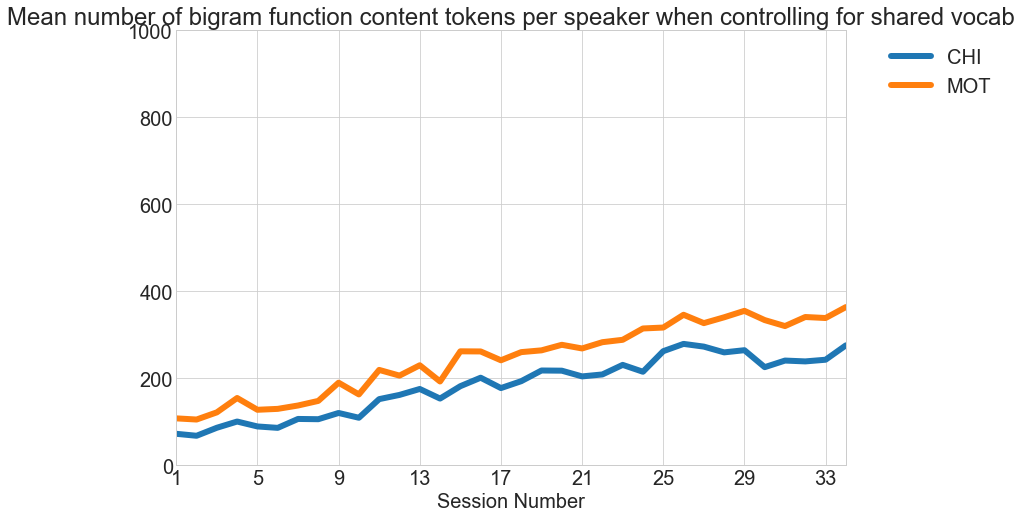

In [35]:
def mean_number_of_tokens_plots():
    unfiltered = (
        bigrams[bigrams.fcat.eq('F/C')]
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.size()
        .unstack()
        .groupby(level='session').mean()
    )
   
    filtered = (
        bigrams[bigrams.fcat.eq('F/C')]
        .groupby(['corpus', 'session'])
        .apply(filter_to_common_vocab)
        .groupby(['corpus', 'session', 'speaker'])
        .ngram.size()
        .unstack()
        .groupby(level='session').mean()
    )
    
    unfiltered.plot()
    plt.ylim(0, 1000)
    vvv_format(title='Mean number of bigram function content tokens per speaker', autoscale=True)
    
    filtered.plot()
    plt.ylim(0, 1000)
    vvv_format(title='Mean number of bigram function content tokens per speaker when controlling for shared vocab', autoscale=True)

mean_number_of_tokens_plots()

In [7]:
def comparative_plot(pairs):
    for df, label in pairs:
        groups = df.groupby(['corpus', 'session']).apply(morisita_child_adult)
        stats = groups.groupby(level='session').describe()
        plt.plot(stats.index, stats['mean'], label=label)

    plt.legend()
    plt.ylim(0, 1)

(0, 1)

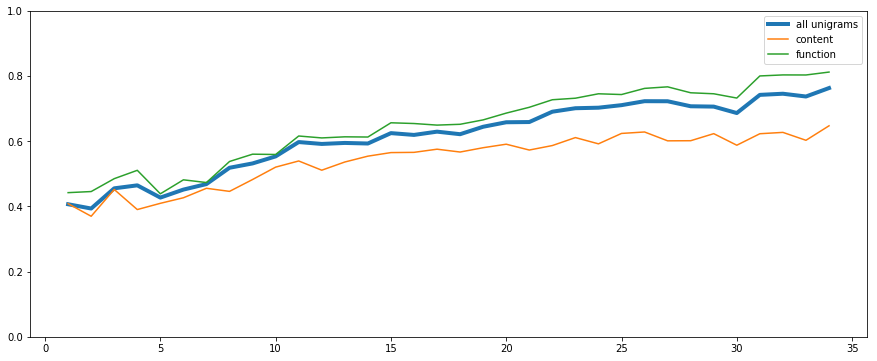

In [8]:
groups = unigrams.groupby(['corpus', 'session']).apply(morisita_child_adult)
stats = groups.groupby(level='session').describe()
plt.plot(stats.index, stats['mean'], label='all unigrams', linewidth=4)

groups = unigrams[unigrams.fcat.eq('C')].groupby(['corpus', 'session']).apply(morisita_child_adult)
stats = groups.groupby(level='session').describe()
plt.plot(stats.index, stats['mean'], label='content')

groups = unigrams[unigrams.fcat.eq('F')].groupby(['corpus', 'session']).apply(morisita_child_adult)
stats = groups.groupby(level='session').describe()
plt.plot(stats.index, stats['mean'], label='function')

plt.legend()
plt.ylim(0, 1)

In [9]:
bigrams['fcat'] = bigrams.ngram.apply(categorize_ngram)

(0, 1)

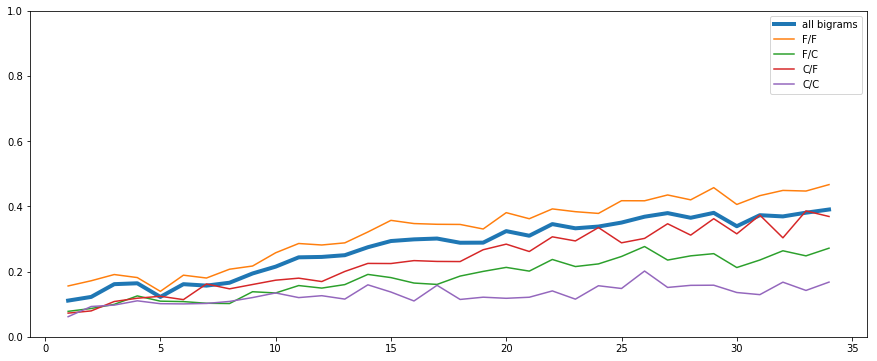

In [10]:
groups = bigrams.groupby(['corpus', 'session']).apply(morisita_child_adult)
stats = groups.groupby(level='session').describe()
plt.plot(stats.index, stats['mean'], label='all bigrams', linewidth=4)

for fcat in ['F/F', 'F/C', 'C/F', 'C/C']:
    groups = bigrams[bigrams.fcat.eq(fcat)].groupby(['corpus', 'session']).apply(morisita_child_adult)
    stats = groups.groupby(level='session').describe()
    plt.plot(stats.index, stats['mean'], label=fcat)
plt.legend()
plt.ylim(0, 1)

In [11]:
def shared_vocab(child_corpus, adult_corpus):
    "Computes the ngrams shared between the two speakers"
    return set(child_corpus.ngram.values) & set(adult_corpus.ngram.values)

def valid_ngram(ngram, shared_vocab): 
    "Returns true if the string `ngrams` only contains words from the shared vocab"
    for word in ngram.split(' '):
        if word not in shared_vocab:
            return False
    return True

# TODO: WTF is going on with nic 16 ??

def morisita_child_adult_cumulative_vocab(unigrams, dataset, corpus, session):
    vocab_source = unigrams[unigrams.corpus.eq(corpus) & unigrams.session.lt(session + 1)]
    vocab = shared_vocab(vocab_source[vocab_source.speaker.eq('CHI')],
                         vocab_source[vocab_source.speaker.eq('MOT')])

    corpus_filter = dataset.corpus.eq(corpus)
    session_filter = dataset.session.eq(session)

    target_utts = dataset[corpus_filter & session_filter]
    child = target_utts[target_utts.speaker.eq('CHI')]
    adult = target_utts[target_utts.speaker.eq('MOT')]

    num_adult_utts = len(adult)
    adult = adult[adult.ngram.apply(lambda ngram: valid_ngram(ngram, vocab))]
    
    if adult.empty:
        return {'morisita': np.nan,
                'corpus': corpus,
                'session': session,
                'discarded_utts': num_adult_utts - len(adult)}
    
    moi = morisita(child.ngram.value_counts(), 
                   adult.ngram.value_counts())
    
    return {'morisita': moi,
            'corpus': corpus,
            'session': session,
            'child_utts': len(child),
            'adult_utts': num_adult_utts,
            'filtered_adult_utts': len(adult)}

In [13]:
dataset=unigrams[unigrams.fcat.eq('C')]
shared_vocab_content_unigrams = pd.DataFrame([
    morisita_child_adult_cumulative_vocab(unigrams, dataset, corpus, session)
    for corpus in dataset.corpus.unique()
    for session in sorted(dataset[dataset.corpus.eq(corpus)].session.unique())])

In [14]:
dataset=unigrams[unigrams.fcat.eq('F')]
shared_vocab_function_unigrams = pd.DataFrame([
    morisita_child_adult_cumulative_vocab(unigrams, dataset, corpus, session)
    for corpus in dataset.corpus.unique()
    for session in sorted(dataset[dataset.corpus.eq(corpus)].session.unique())])

NameError: name 'name' is not defined

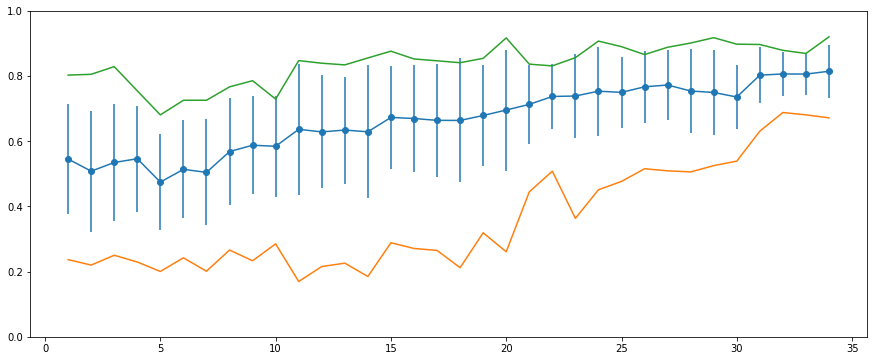

In [15]:
stats = shared_vocab_function_unigrams.groupby('session').morisita.describe()
plt.ylim(0, 1)
plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
plt.plot(stats['min'])
plt.plot(stats['max'])
per_session_plot('Child-Adult {} Function Morisita overlap index limited to cumulative child vocabulary'.format(name))

In [ ]:
stats = shared_vocab_content_unigrams.groupby('session').morisita.describe()
plt.ylim(0, 1)
plt.errorbar(stats.index, stats['mean'], stats['std'], label='mean w/ std', marker='o');
plt.plot(stats['min'])
plt.plot(stats['max'])
per_session_plot('Child-Adult Content {} Morisita overlap index limited to cumulative child vocabulary'.format(name))

In [ ]:
stats = shared_vocab_function_unigrams.groupby('session').morisita.describe()
plt.plot(stats['mean'], label='function')


stats = shared_vocab_content_unigrams.groupby('session').morisita.describe()
plt.plot(stats['mean'], label='content')

plt.legend()
plt.ylim(0, 1);

In [ ]:
shared_vocab_bigrams = {}

for pair in ['F/F', 'F/C', 'C/F', 'C/C']:
    dataset=bigrams[bigrams.fcat.eq(pair)]
    shared_vocab_bigrams[pair] = pd.DataFrame([
        morisita_child_adult_cumulative_vocab(unigrams, dataset, corpus, session)
        for corpus in dataset.corpus.unique()
        for session in sorted(dataset[dataset.corpus.eq(corpus)].session.unique())])

In [ ]:
for group in ['F/F', 'F/C', 'C/F', 'C/C']:
    stats = shared_vocab_bigrams[group].groupby('session').morisita.describe()
    plt.plot(stats['mean'], label=group).text(stats.index[-1], stats['mean'].values[-1], group)
    plt.legend()
    
plt.ylim(0, 1);

In [ ]:
stats['mean'].values[-1]